In [1]:
import numpy as np
import xarray as xr

import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
from matplotlib import ticker, cm

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
import dask
from dask.diagnostics import ProgressBar
from functools import partial

#fft packages
from scipy import fftpack
import math
from scipy import fft
from scipy import ndimage
from scipy import signal

In [2]:
#swicth back to plotting defaults
#plt.rcdefaults()

In [3]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [4]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [5]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            #IOP03
            if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num)         
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','wtheta','wq','u','v']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds

#from Luise Wanner
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)

def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

In [6]:
def rotate_var (var,factor,wind_angle):
    data_array = var

    #scipy ndimage needs integer valued arrays for rotation
    #so multiplying and dividing by 1000 to convert to and back from 3 degree precision integers
    rotated_data = ((ndimage.rotate(np.nan_to_num((data_array*factor)).astype(int), angle=wind_angle,reshape=False))/factor)
    # plt.imshow(data_array,origin = 'lower', cmap = 'RdBu_r')
    # plt.colorbar()
    return rotated_data

def critical_wavelength_spectrum(S, k):
    cumsum = np.cumsum(np.flip((S*np.diff(k)[0])))
    #find the 2/3rd variance value from the integral
    critical_var = cumsum[-1]*2/3
    #find the index of this critical variance
    f_index = np.where(np.cumsum(cumsum > critical_var) == 1)
    critical_wavelength = (1/np.flip(k)[f_index])
    # print('critical_wavelength: ' , critical_wavelength)
    return critical_wavelength


In [7]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

In [8]:
IOP02_time_array = ['2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000']

#using theta, ensemble mean
zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 
zi_iop02_hom = [ 524.81832925, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773]
u_star_array_iop02 = [0.23746523, 0.26933923, 0.34820446, 0.3888348 , 0.41974205,
       0.4338308 , 0.42021513, 0.41170758, 0.427308  , 0.4327292 ,
       0.41003117, 0.37822667, 0.37520644, 0.37473503, 0.35841644]
u_star_array_iop02_hom = [0.370922  , 0.37005759, 0.36280847, 0.37263662, 0.38041674,
       0.35737035, 0.33413935, 0.29965769, 0.29071767, 0.27624321,
       0.24543684]#1100 to 1600
w_star_iop02 = [0.65544301, 0.8218802 , 1.15222044, 1.33399153, 1.55739   ,
       1.80245719, 1.79051632, 1.88647701, 2.07238861, 2.06652333,
       2.0011327 , 1.89977991, 1.93889857, 1.9215422 , 1.82642433]
theta_star_iop02 = [0.38440898, 0.41200343, 0.453697  , 0.4463509 , 0.42065033,
       0.38860902, 0.37801373, 0.45171738, 0.4704315 , 0.4525797 ,
       0.37480488, 0.40305007, 0.41563264, 0.36649814, 0.31710973]
q_star_iop02 = [0.00021279, 0.00022559, 0.00024026, 0.00026083, 0.0002838 ,
       0.00027884, 0.0002789 , 0.00030576, 0.00030606, 0.00030307,
       0.00028612, 0.0003129 , 0.00031593, 0.0003026 , 0.00029867]

In [9]:
IOP03_time_array = ['2019-09-24T09:00:00.000000000', '2019-09-24T09:30:00.000000000',
       '2019-09-24T10:00:00.000000000', '2019-09-24T10:30:00.000000000',
       '2019-09-24T11:00:00.000000000', '2019-09-24T11:30:00.000000000',
       '2019-09-24T12:00:00.000000000', '2019-09-24T12:30:00.000000000',
       '2019-09-24T13:00:00.000000000', '2019-09-24T13:30:00.000000000',
       '2019-09-24T14:00:00.000000000', '2019-09-24T14:30:00.000000000']

zi_iop03 = [  89.55689018,  146.17518378,  222.75052796,  318.65739363,
        391.70175986,  465.53290265,  578.09552239,  665.90258855,
        747.14683894,  854.98633994,  961.446683  , 1046.67977723]

zi_iop03_hom = [ 85.71667632, 128.70966362, 186.86216084, 280.04332368,
       365.78988639, 493.88155937, 654.26742704, 754.06946759,
       830.85984406, 902.44667409, 950.16213856, 989.2927779 ]

u_star_array_iop03 = [0.10734038, 0.346752  , 0.42885262, 0.4882605 , 0.5238576 ,
       0.573982  , 0.60698235, 0.6250409 , 0.63989866, 0.6486785 ,
       0.651481  , 0.62593067]
u_star_array_iop03_hom = [ 0.09917983,  0.18773973,  0.31439638,  0.41304964,  0.45929348,
        0.49533993,  0.5244337 ,  0.5403172 , 44.93412   , 59.729065  ,
        0.5259894 ,  0.49205783]

theta_star_list_iop03 = [0.26582974, 0.22147681, 0.22207852, 0.20489082, 0.21669415,
       0.22336227, 0.2157141 , 0.20650086, 0.20044297, 0.18935573,
       0.17518993, 0.08177642]
theta_star_list_iop03_hom = [0.51723352, 0.39963672, 0.3056469 , 0.26371197, 0.26017615,
        0.25168263, 0.24436416, 0.23780183, 0.00277911, 0.00173605,
        0.15013228, 0.06724547]

w_star_list_iop03 = [0.28552411, 0.72898643, 0.80803615, 0.88109926, 0.94235606,
       1.07701186, 1.16389994, 1.21709966, 1.25004394, 1.28395841,
       1.31412257, 1.22432382]
w_star_list_iop03_hom = [0.5524251 , 0.71308628, 0.8732285 , 1.04171937, 1.17461117,
       1.31692814, 1.46028364, 1.52774717, 1.56301413, 1.52505127,
       1.43029462, 1.13401229]

#### Data input

In [10]:
ensemble_member_ds_2_P = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
ensemble_member_ds_2_N02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_member_ds_2_N03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4209798164665699 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3247719705104828 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.33311670273542404 seconds


In [11]:
ensemble_member_ds_2_P_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop03')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_member_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.32510771974921227 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.32203830033540726 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.41938191279768944 seconds


In [12]:
profile_P_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
profile_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.9879392944276333 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.3257101736962795 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.7425358705222607 seconds


In [13]:
# #time series data for member2
# ts_N02_member_2_ds_iop02 = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop02')
# ts_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop03')


In [14]:
ensemble_member_ds_2_N02_inst = open_concat_member_files(2,'DATA_3D_NETCDF_N02slice','iop02')
ensemble_member_ds_2_N02_inst_iop03 = open_concat_member_files(2,'DATA_3D_NETCDF_N02slice','iop03')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.28437964990735054 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.38257433474063873 seconds


In [15]:
ensemble_member_surf_ds_2_P = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop02')
ensemble_member_surf_ds_2_N02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')
ensemble_member_surf_ds_2_N03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2806898280978203 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.28034864366054535 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3324562683701515 seconds


In [16]:
ensemble_member_surf_ds_2_P_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop03')
ensemble_member_surf_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop03')
ensemble_member_surf_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2807348780333996 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2909192219376564 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4826572611927986 seconds


In [17]:
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.3133932910859585 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.284364715218544 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.2786817364394665 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.28092

In [18]:
member_list = np.arange(0,8)

ensemble_ds_iop03_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02 = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.7326357327401638 seconds
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.3642350360751152 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.288126

In [19]:
#subset it for the 10x10 smaller domain 
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

#ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_2_het_iop02 = ensemble_member_ds_2_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_surf_iop02 = ensemble_member_surf_ds_2_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    # ds['xu'] = ds.xu - ds.xu[0]
    # ds['yv'] = ds.yv - ds.yv[0]
    
    
    return (ds)

ds_het_iop02 = adjust_axis(ds_het_iop02)
ds_2_het_iop02 = adjust_axis(ds_2_het_iop02)
ds_2_het_surf_iop02 = adjust_axis(ds_2_het_surf_iop02)




In [20]:
#iop03
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

#ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_het_iop03 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_iop03 = ensemble_member_ds_2_N02_iop03.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))



def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    ds['xu'] = ds.xu - ds.xu[0]
    ds['yv'] = ds.yv - ds.yv[0]
    
    
    return (ds)

ds_het_iop03 = adjust_axis(ds_het_iop03)
ds_2_het_iop03 = adjust_axis(ds_2_het_iop03)



#### Charcaterisitc T and q fields, T* and q*

IOP02

[########################################] | 100% Completed | 101.66 ms
[########################################] | 100% Completed | 101.35 ms


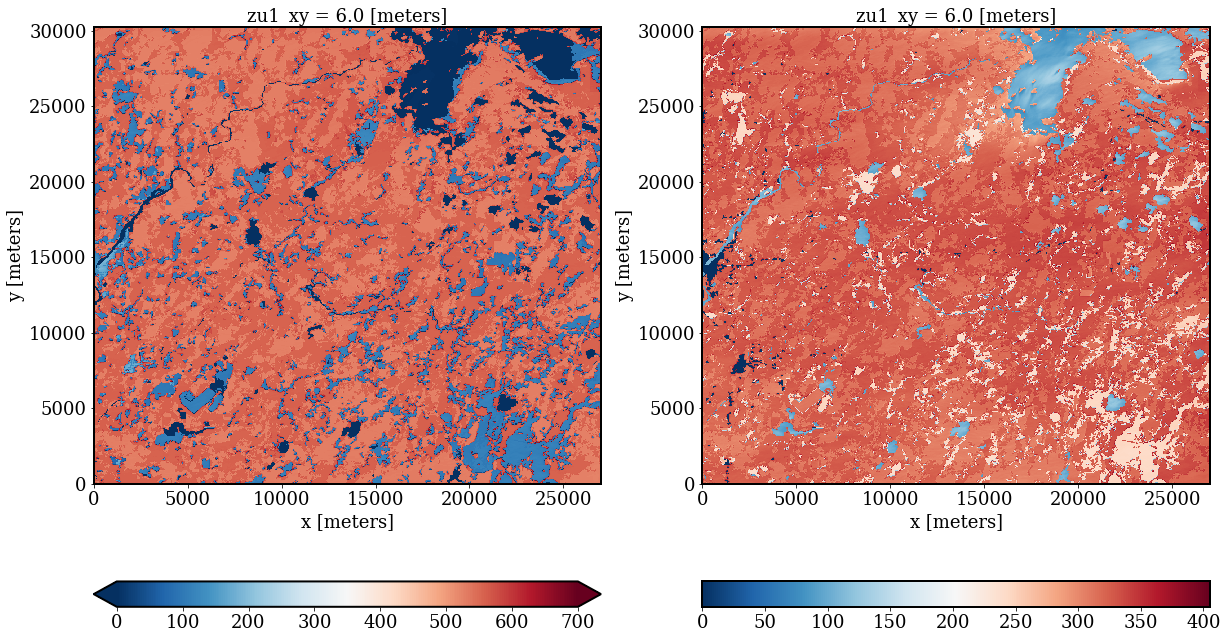

In [32]:
###---------------------------------------------------
#PCM fluxes in the domains

N02_H_PCM = (ensemble_member_ds_2_N02.pcm_heatrate.sel(time='2019-08-23T11:00:00.000000000').sum('zpc_3d')*1.17*1005*12)

N02_LE_PCM = (ensemble_member_ds_2_N02.pcm_latentrate.sel(time='2019-08-23T11:00:00.000000000').sum('zpc_3d')*1.17*1005*12)


###---------------------------------------------------
#surface fluxes in the domains
N02_H_surf = ensemble_member_surf_ds_2_N02['shf*_xy'].isel(time=71)

N02_LE_surf = ensemble_member_surf_ds_2_N02['qsws*_xy'].isel(time=71)

###---------------------------------------------------

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

(N02_H_surf+N02_H_PCM).plot(ax=ax1,cmap='RdBu_r',vmin=0,vmax=700,cbar_kwargs={'location':'bottom'})
(N02_LE_surf+N02_LE_PCM).plot(ax=ax2,cmap='RdBu_r',cbar_kwargs={'location':'bottom'})#,vmin=0,vmax=400,


They look good!

[########################################] | 100% Completed | 101.51 ms


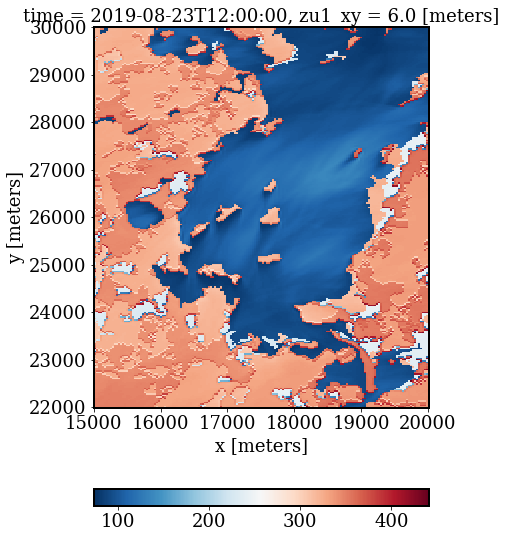

In [18]:
(N02_LE_surf+N02_LE_PCM).sel(x=slice(15000,20000),y=slice(22000,30000)).plot(figsize=(6,10),cmap='RdBu_r',cbar_kwargs={'location':'bottom'})#,vmin=0,vmax=400,



[########################################] | 100% Completed | 101.52 ms
[########################################] | 100% Completed | 101.36 ms


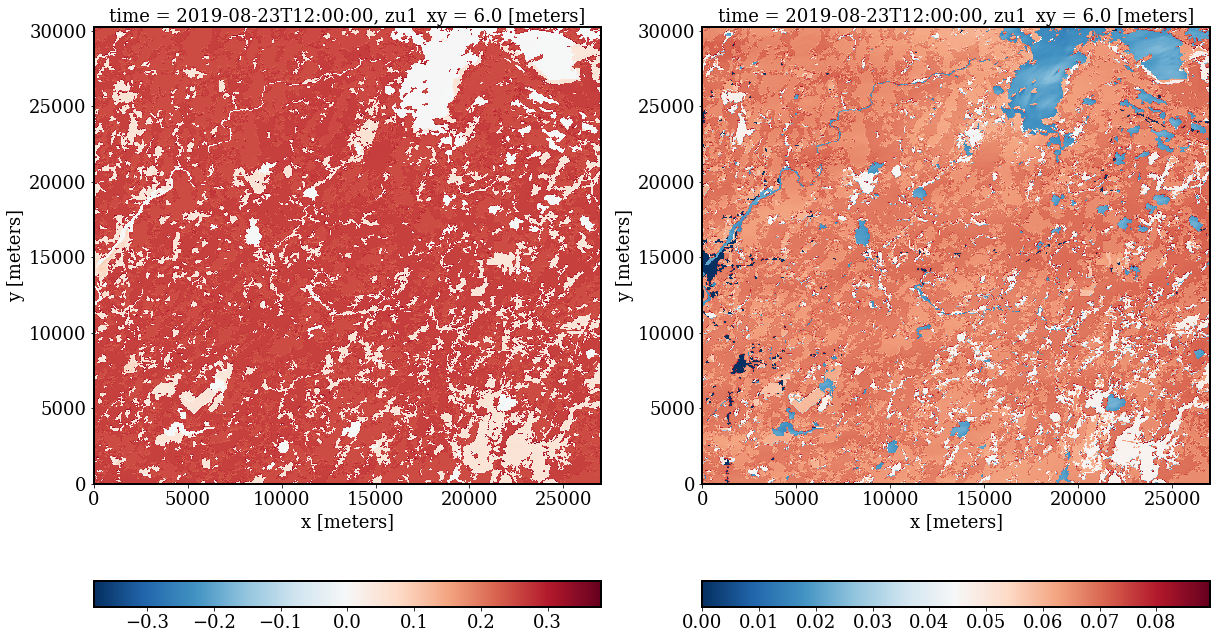

In [33]:
#characteristic scalar fields
#dividng the fluxes by w*
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

((N02_H_surf+N02_H_PCM)/(1.8*1.17*1005)).plot(ax=ax1,cmap='RdBu_r',cbar_kwargs={'location':'bottom'})
((N02_LE_surf+N02_LE_PCM)/(1.8*1.17*2501)).plot(ax=ax2,cmap='RdBu_r',cbar_kwargs={'location':'bottom'})


Looks as if I'm just scaling them. So, *shrugs

iop02

In [20]:
time_list = IOP02_time_array

surface_T_list = []
surface_q_list = []

for i, time_step in enumerate(time_list):

    #PCM fluxes in the domains

    N02_H_PCM = (ensemble_member_ds_2_N02.pcm_heatrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)

    N02_LE_PCM = (ensemble_member_ds_2_N02.pcm_latentrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)


    ###---------------------------------------------------
    #surface fluxes in the domains
    N02_H_surf = ensemble_member_surf_ds_2_N02['shf*_xy'].sel(time=time_step)

    N02_LE_surf = ensemble_member_surf_ds_2_N02['qsws*_xy'].sel(time=time_step)

    ###---------------------------------------------------
    
    N02_net_H_kinematic = (N02_H_surf+N02_H_PCM)/(1.17*1005)
    N02_net_LE_kinematic = (N02_LE_surf+N02_LE_PCM)/(1.17*2501)
    
    surface_T = N02_net_H_kinematic/u_star_array_iop02[i]
    surface_q = N02_net_LE_kinematic/u_star_array_iop02[i]

    # surface_T = N02_net_H_kinematic/w_star_array[i]
    # surface_q = N02_net_LE_kinematic/w_star_array[i]

    surface_T_list.append(surface_T)
    surface_q_list.append(surface_q)

surface_T_ds_iop02 =  xr.concat(surface_T_list,dim='time')
surface_q_ds_iop02 =  xr.concat(surface_q_list,dim='time')


iop03

In [52]:
# time_list = IOP02_time_array

# surface_T_list = []
# surface_q_list = []

# for i, time_step in enumerate(time_list):

#     #PCM fluxes in the domains

#     N02_H_PCM = (ensemble_member_ds_2_N02_iop03.pcm_heatrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)

#     N02_LE_PCM = (ensemble_member_ds_2_N02_iop03.pcm_latentrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)


#     ###---------------------------------------------------
#     #surface fluxes in the domains
#     N02_H_surf = ensemble_member_surf_ds_2_N02_iop03['shf*_xy'].sel(time=time_step)

#     N02_LE_surf = ensemble_member_surf_ds_2_N02_iop03['qsws*_xy'].sel(time=time_step)

#     ###---------------------------------------------------
    
#     N02_net_H_kinematic = (N02_H_surf+N02_H_PCM)/(1.17*1005)
#     N02_net_LE_kinematic = (N02_LE_surf+N02_LE_PCM)/(1.17*2501)
    
#     # surface_T = N02_net_H_kinematic/w_star_array[i]
#     # surface_q = N02_net_LE_kinematic/w_star_array[i]

#     surface_T = N02_net_H_kinematic/u_star_array_iop03[i]
#     surface_q = N02_net_LE_kinematic/u_star_array_iop03[i]

#     surface_T_list.append(surface_T)
#     surface_q_list.append(surface_q)

# surface_T_ds_iop03 =  xr.concat(surface_T_list,dim='time')
# surface_q_ds_iop03 =  xr.concat(surface_q_list,dim='time')


In [6]:
#from Luise Wanner
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)


In [7]:
def calcLh(T_surf,x,y):
    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size
    
    # # find center of area
    # yloc = int(len(x)/2)
    # xloc = int(len(y)/2)
    # find 10 evenly spaced transects along each direction
    ylocs = np.round(np.arange(5,Nx,Nx/10),0).astype(int)
    xlocs = np.round(np.arange(5,Ny,Ny/10),0).astype(int)
    
    lx = []
    ly = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        # Tx = T_surf[:,xloc]-T_surf[:,xloc].mean()
        # Ty = T_surf[yloc,:]-T_surf[yloc,:].mean()
        Ty = T_surf[:,xloc]-T_surf[:,xloc].mean()
        Tx = T_surf[yloc,:]-T_surf[yloc,:].mean()
        
        #-- apply bell taper to space series
        Tx_bt = belltaper(Tx,Nx)     
        Ty_bt = belltaper(Ty,Ny)
        
        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = np.abs(fftpack.fft(Tx_bt)[:int(Nx/2)])
        Sy = np.abs(fftpack.fft(Ty_bt)[:int(Ny/2)])           
    
        # extracting wavelength of spectrum maximum
        k_x_max = k_x[np.where(Sx == Sx.max())][0]
        k_y_max = k_y[np.where(Sy == Sy.max())][0]
        
        # determining l_x by simply converting 1/m to m
        lx.append(1/k_x_max)
        ly.append(1/k_y_max)
    l_x = np.mean(lx)
    l_y = np.mean(ly)   
    # heterogeneity scale is 1/2 l, average over x- and y-direction
    if (0.5*l_x + 0.5*l_y)/2 > 100000:
        return(np.nan) # nan 
    else:
        return((0.5*l_x + 0.5*l_y)*0.5) 

In [61]:

dataset = surface_T_ds_iop03
length_scale_list = []

for i, time_step in enumerate(dataset.time.values):
    
    T_surf = dataset.isel(time=i).values[0]
    x = dataset.isel(time=i).x.values
    y = dataset.isel(time=i).y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    # yloc = int(len(x)/2)
    # xloc = int(len(y)/2)
    # find 10 evenly spaced transects along each direction
    # ylocs = np.round(np.arange(5,Nx,Nx/10),0).astype(int)
    # xlocs = np.round(np.arange(5,Ny,Ny/10),0).astype(int)
    array_size = 400
    xlocs = np.round(np.arange(5,Nx,Nx/array_size),0).astype(int)
    ylocs = np.round(np.arange(5,Ny,Ny/array_size),0).astype(int)


    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        Ty = T_surf[:,xloc]-T_surf[:,xloc].mean()
        Tx = T_surf[yloc,:]-T_surf[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        Tx_bt = belltaper(Tx,Nx)     
        Ty_bt = belltaper(Ty,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(Tx_bt)**2)[:int(Nx/2)])
        Sy = (np.abs(fftpack.fft(Ty_bt)**2)[:int(Ny/2)])           
        # extracting wavelength of spectrum maximum
        k_x_max = k_x[np.where(Sx == Sx.max())][0]
        k_y_max = k_y[np.where(Sy == Sy.max())][0]

        # determining l_x by simply converting 1/m to m
        lx.append(1/k_x_max)
        ly.append(1/k_y_max)
    l_x = np.mean(lx)
    l_y = np.mean(ly)   

    # heterogeneity scale is 1/2 l, average over x- and y-direction
    if (0.5*l_x + 0.5*l_y)/2 > 100000:
        length_scale_list.append(np.nan) # nan 
    else:
        length_scale_list.append((0.5*l_x + 0.5*l_y)*0.5) 

[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.20 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.23 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.25 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.40 ms


In [62]:
T_length_scale_list = length_scale_list
#q_length_scale_list = length_scale_list

For now, reading in values from 1D FFT, means of Lx and Ly. Update later, with just Ly

In [16]:
#T_length_scale_iop02 = np.asarray(T_length_scale_list)
#print(T_length_scale)
T_length_scale_iop02 = np.asarray([1187.44, 1321.5,  1324.46, 1320.26, 1291.61, 1298.5,  1327.91, 1328.33, 1326.18,
                         1292.47, 1314.82, 1314.98, 1310.84, 1252.01, 1172.2,  1109.67, 1142.13])

#q_length_scale_iop02 = np.asarray(q_length_scale_list)
#print(q_length_scale)
q_length_scale_iop02 = np.asarray([1190.26, 1526.97, 1479.63, 1462.47, 1401.78, 1495.66, 1421.29, 1460.09, 1341.56,
                         1258.26, 1359.46, 1343.75, 1364.16, 1265.9,  1088.61, 1075.21, 1058.07])

#Tv_length_scale_iop02 = np.asarray(Tv_length_scale_list)
Tv_length_scale_iop02 = np.asarray([1209.71, 1535.09, 1489.43, 1476.45, 1411.9,  1495.74, 1418.69, 1460.74, 1346.57,
                         1260.03, 1343.87, 1344.41, 1354.62, 1263.58, 1091.1,  1083.56, 1058.45])


In [54]:
time_stamp =  (surface_T_ds_iop02['time'].dt.strftime('%H:%M'))


In [55]:
time_stamp.values

array(['09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00',
       '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30',
       '16:00'], dtype=object)

In [57]:
T_length_scale_iop02

array([1187.44, 1321.5 , 1324.46, 1320.26, 1291.61, 1298.5 , 1327.91,
       1328.33, 1326.18, 1292.47, 1314.82, 1314.98, 1310.84, 1252.01,
       1172.2 , 1109.67, 1142.13])

In [58]:
q_length_scale_iop02

array([1190.26, 1526.97, 1479.63, 1462.47, 1401.78, 1495.66, 1421.29,
       1460.09, 1341.56, 1258.26, 1359.46, 1343.75, 1364.16, 1265.9 ,
       1088.61, 1075.21, 1058.07])

In [11]:
#read in the instantaneous  values, then pick a transect and calculate the PSD, and plot it vs, k

ensemble_member_ds_2_N02_inst = open_concat_member_files(2,'DATA_3D_NETCDF_N02slice','iop02')


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2804312240332365 seconds


In [251]:
#extract w_data for one transect for now
w_data = ensemble_member_ds_2_N02_inst.w.sel(time='2019-08-23T11:00:00.000000000',zw_3d=60,x=1500,method='nearest')

In [260]:
f, Pxy = signal.welch(w_data.values, fs=1/30)


[########################################] | 100% Completed | 101.43 ms


/tmp/ipykernel_2271657/2897061895.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/f, np.abs(Pxy))


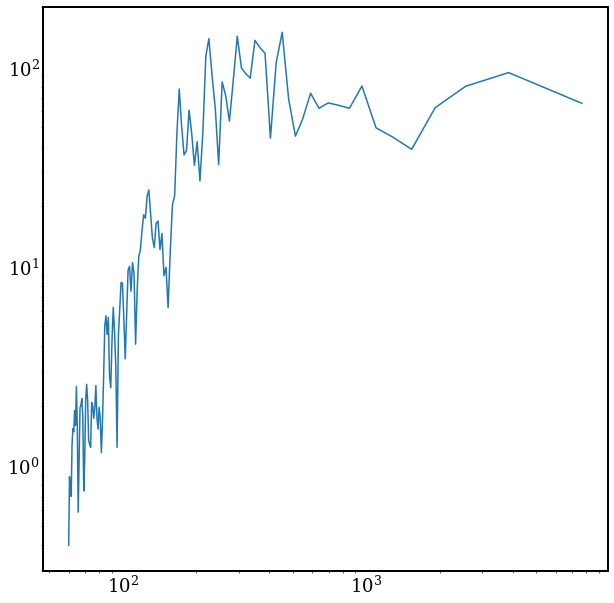

In [261]:
plt.figure(figsize=(8,8))
plt.loglog(1/f, np.abs(Pxy))


In [17]:

spec_power_list_y = np.zeros(int(ensemble_member_ds_2_N02_inst.y.size/2))

for x_value in ensemble_member_ds_2_N02_inst.x.values:

    w_data = ensemble_member_ds_2_N02_inst.w.sel(time='2019-08-23T11:00:00.000000000',zw_3d=60,x=x_value,method='nearest')

    data = w_data.values
    #x = dataset.x.values
    y = w_data.y.values

    # number of obsevations in x- and y-direction
    #Nx = x.size
    Ny = y.size

    #-- calculate wave vectors
    # grid spacing
    #dx = x[1]-x[0]
    dy = y[1]-y[0]
    # dimensions of whole domain
    #Lx = dx*Nx
    Ly = dy*Ny
    # nyquist aliasing frequency
    #nyquist_x = np.power(dx,-1)/2
    nyquist_y = np.power(dy,-1)/2
    spec_power = np.abs((fft.fft(data)[:int(Ny/2)])**2)
    spec_power_list_y = spec_power_list_y + spec_power

[########################################] | 100% Completed | 101.68 ms
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 101.01 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.09 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 101.04 ms
[########################################] | 100% Completed | 10

In [14]:

spec_power_list_x = np.zeros(int(ensemble_member_ds_2_N02_inst.x.size/2))

for y_value in ensemble_member_ds_2_N02_inst.y.values:

    w_data = ensemble_member_ds_2_N02_inst.w.sel(time='2019-08-23T10:00:00.000000000',zw_3d=60,y=y_value,method='nearest')

    data = w_data.values
    x = w_data.x.values
    # y = w_data.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    # Ny = y.size

    #-- calculate wave vectors
    # grid spacing
    dx = x[1]-x[0]
    #dy = y[1]-y[0]
    # dimensions of whole domain
    Lx = dx*Nx
    #Ly = dy*Ny
    # nyquist aliasing frequency
    #nyquist_x = np.power(dx,-1)/2
    #nyquist_y = np.power(dy,-1)/2
    spec_power = np.abs((fft.fft(data)[:int(Nx/2)])**2)
    spec_power_list_x = spec_power_list_x + spec_power

[########################################] | 100% Completed | 101.09 ms
[########################################] | 100% Completed | 100.99 ms
[########################################] | 100% Completed | 100.76 ms
[########################################] | 100% Completed | 100.99 ms
[########################################] | 100% Completed | 100.83 ms
[########################################] | 100% Completed | 100.79 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 100.99 ms
[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 10

/tmp/ipykernel_2020866/4085996908.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_y,spec_power_list_y/np.size(spec_power_list_y))


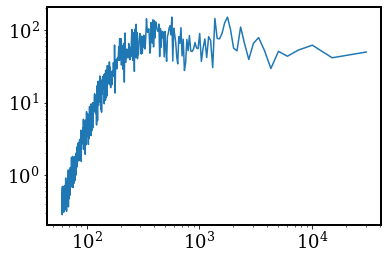

In [84]:
freq_y = fft.fftfreq(int(Ly))[:int(Ny/2)]
plt.loglog(1/freq_y,spec_power_list_y/np.size(spec_power_list_y))


I had a look at the spectra averaged over 25 transects, to see how it would look like if I were to pick 3 instantaneous transects over an hour at say 1000, 1030, 1100 and then average over 8 ensembles. Looks like there is still some noise at the high freq, range.\
But I can totaly bin this spectra and see what happens. 

/tmp/ipykernel_2202491/60784087.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_y,spec_power_list_y/np.size(spec_power_list_y))
/tmp/ipykernel_2202491/60784087.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_x,spec_power_list_x/np.size(spec_power_list_x))


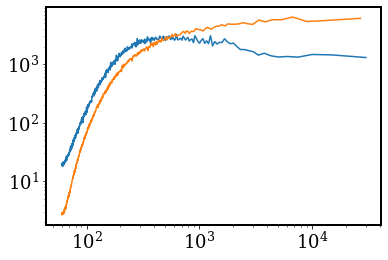

In [18]:
freq_y = fft.fftfreq(int(Ly))[:int(Ny/2)]
plt.loglog(1/freq_y,spec_power_list_y/np.size(spec_power_list_y))
freq_x = fft.fftfreq(int(Lx))[:int(Nx/2)]
plt.loglog(1/freq_x,spec_power_list_x/np.size(spec_power_list_x))


In [53]:
freq_x[:450].size

450

In [ ]:
#averaging the spectral powers in x and y,
spec_power = (spec_power_list_y[:449] + spec_power_list_x[1:])/2
freq = np.sqrt((freq_y[:449]**2 + freq_x[1:]**2)/2)
plt.loglog(1/freq,spec_power)


I'm gonna redo the same for 1100 CDT and for T and q data

In [19]:
#test function
#spec_power_list = np.zeros(503)
#'2019-08-23T10:00:00.000000000'

def spec_power_hzntl(data_ds, zw, _var, _dim, time_step):

    #_dim is the spatial dimension along which the spectra is calculated 
    #define the lengths, delta_ and all that
    if _dim == 'x' :
        averaging_dim = 'y'
        
        #sampling_points
        if _var == 'w' : distances = data_ds[_var].sel(time=time_step,zw_3d=zw,method='nearest').x.values
       
        if _var != 'w' : distances = data_ds[_var].sel(time=time_step,zu_3d=zw,method='nearest').x.values
        
        N = distances.size
        #sample distance
        delta = distances[1]-distances[0]
        #window length
        L = delta*N
        
        nyquist = np.power(delta,-1)/2
        spec_power_list = np.zeros(int(N/2))
        
    
    if _dim == 'y' :
        averaging_dim = 'x'
        
        #sampling_points
        if _var == 'w' : distances = data_ds[_var].sel(time=time_step,zw_3d=zw,method='nearest').y.values
        
        if _var != 'w' : distances = data_ds[_var].sel(time=time_step,zu_3d=zw,method='nearest').y.values
        
        N = distances.size
        #sample distance
        delta = distances[1]-distances[0]
        #window length
        L = delta*N
        
        nyquist = np.power(delta,-1)/2
        spec_power_list = np.zeros(int(N/2))


    
    for value in data_ds[averaging_dim].values:
        
        #select the data array

        if _var == 'w':            
            if _dim == 'y' : data_array = data_ds[_var].sel(time=time_step,zw_3d=zw,x=value,method='nearest')
            if _dim == 'x' : data_array = data_ds[_var].sel(time=time_step,zw_3d=zw,y=value,method='nearest')

        if _var != 'w':            
            if _dim == 'y' : data_array = data_ds[_var].sel(time=time_step,zu_3d=zw,x=value,method='nearest')
            if _dim == 'x' : data_array = data_ds[_var].sel(time=time_step,zu_3d=zw,y=value,method='nearest')

        data = data_array.values
        
        #remove the mean and 
        #taper the ends of the data using cosine weighting for the first and last 10%
        data_bt = belltaper(data-np.mean(data),N)     
        
        spec_power = np.abs((fft.fft(data_bt)[:int(N/2)])**2)
        
        spec_power_list = spec_power_list + spec_power
    
    return(spec_power_list)

Function test

Continue with calculating the spectra at 11:00 for w, T, q

In [95]:
#1100
#w, 60 m
spec_power_list_w_1100y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','y','2019-08-23T11:00:00.000000000')
spec_power_list_w_1100x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','x','2019-08-23T11:00:00.000000000')

[########################################] | 100% Completed | 101.91 ms
[########################################] | 100% Completed | 101.09 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 100.87 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 101.07 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 10

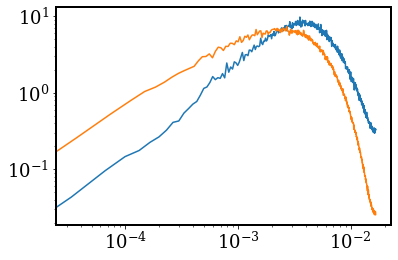

In [80]:
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
PS_y = spec_power_list_w_1100y_60m
PS_x = spec_power_list_w_1100x_60m
plt.loglog(freq_y,(PS_y/np.size(PS_y))*freq_y)
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]
plt.loglog(freq_x,(PS_x/np.size(PS_x))*freq_x)


/tmp/ipykernel_2020866/1145038575.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq)


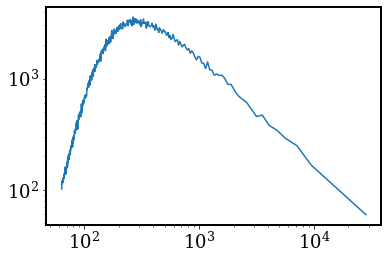

In [87]:
#averaging the spectral powers in x and y,
spec_power = (PS_y[:450] + spec_power_list_x)/2
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)
plt.figure()
plt.loglog(1/freq,spec_power*freq)


Max power at scales ~ 200 m

In [91]:
#let's go higher up to 0.5 zi at 329 m
#1100
#w, 329 m
spec_power_list_w_1100y_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'w','y','2019-08-23T11:00:00.000000000')
spec_power_list_w_1100x_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'w','x','2019-08-23T11:00:00.000000000')

[########################################] | 100% Completed | 101.64 ms
[########################################] | 100% Completed | 100.99 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 101.09 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 101.02 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 10

/tmp/ipykernel_2020866/3706484347.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_y,(PS_y/np.size(PS_y))*freq_y)
/tmp/ipykernel_2020866/3706484347.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_x,(PS_x/np.size(PS_x))*freq_x)


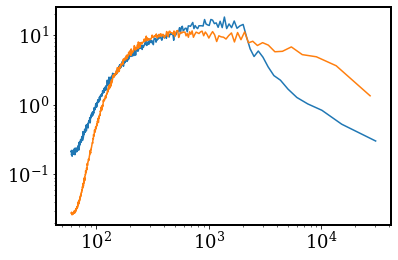

In [94]:
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
PS_y = spec_power_list_w_1100y_329m
PS_x = spec_power_list_w_1100x_329m
plt.loglog(1/freq_y,(PS_y/np.size(PS_y))*freq_y)
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]
plt.loglog(1/freq_x,(PS_x/np.size(PS_x))*freq_x)


/tmp/ipykernel_2020866/1145038575.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq)


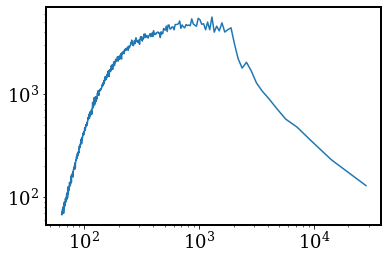

In [93]:
#averaging the spectral powers in x and y,
spec_power = (PS_y[:450] + spec_power_list_x)/2
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)
plt.figure()
plt.loglog(1/freq,spec_power*freq)


In [96]:
#let's go higher up to 0.5 zi at 650 m
#1100
#w, 650 m
spec_power_list_w_1100y_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'w','y','2019-08-23T11:00:00.000000000')
spec_power_list_w_1100x_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'w','x','2019-08-23T11:00:00.000000000')

[########################################] | 100% Completed | 101.59 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.09 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.89 ms
[########################################] | 100% Completed | 10

/tmp/ipykernel_2020866/3545777543.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_y,(PS_y/np.size(PS_y))*freq_y)
/tmp/ipykernel_2020866/3545777543.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq_x,(PS_x/np.size(PS_x))*freq_x)


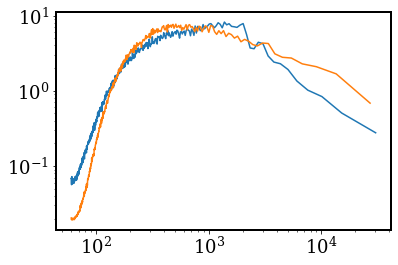

In [97]:
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

PS_y = spec_power_list_w_1100y_650m
PS_x = spec_power_list_w_1100x_650m

plt.loglog(1/freq_y,(PS_y/np.size(PS_y))*freq_y)
plt.loglog(1/freq_x,(PS_x/np.size(PS_x))*freq_x)


/tmp/ipykernel_2020866/983999193.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq)


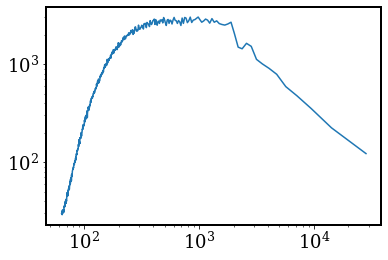

In [98]:
#averaging the spectral powers in x and y,
spec_power = (PS_y[:450] + spec_power_list_x)/2
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.figure()
plt.loglog(1/freq,spec_power*freq)


Compare bw surface, 0.5zi and zi spectra

/tmp/ipykernel_2020866/2748109197.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/2748109197.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/2748109197.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


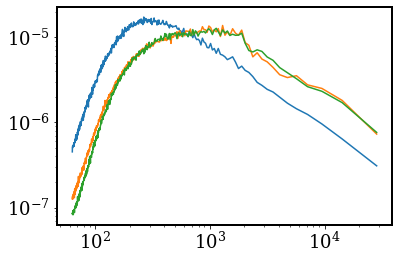

In [113]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#0.1zi
PS_y = spec_power_list_w_1100y_60m
PS_x = spec_power_list_w_1100x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_w_1100y_329m
PS_x = spec_power_list_w_1100x_329m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_w_1100y_650m
PS_x = spec_power_list_w_1100x_650m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


In [106]:
#save the spectral arrays
#0.1zi
np.save('work/scale_analysis/spec_power_list_w_1100y_60m.npy', spec_power_list_w_1100y_60m)
np.save('work/scale_analysis/spec_power_list_w_1100x_60m.npy', spec_power_list_w_1100x_60m)

#0.5zi
np.save('work/scale_analysis/spec_power_list_w_1100y_329m.npy', spec_power_list_w_1100y_329m)
np.save('work/scale_analysis/spec_power_list_w_1100x_329m.npy', spec_power_list_w_1100x_329m)

#zi
np.save( 'work/scale_analysis/spec_power_list_w_1100y_650m.npy', spec_power_list_w_1100y_650m)
np.save( 'work/scale_analysis/spec_power_list_w_1100x_650m.npy', spec_power_list_w_1100x_650m)


Repeat the same, first for q

In [169]:
#1100
#q, 60 m
spec_power_list_q_1100y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','y','2019-08-23T11:00:00.000000000')
spec_power_list_q_1100x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','x','2019-08-23T11:00:00.000000000')

#1100
#q, 329 m
spec_power_list_q_1100y_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'q','y','2019-08-23T11:00:00.000000000')
spec_power_list_q_1100x_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'q','x','2019-08-23T11:00:00.000000000')

#1100
#q, 650 m
spec_power_list_q_1100y_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'q','y','2019-08-23T11:00:00.000000000')
spec_power_list_q_1100x_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'q','x','2019-08-23T11:00:00.000000000')

[########################################] | 100% Completed | 101.70 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 101.04 ms
[########################################] | 100% Completed | 101.02 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 10

/tmp/ipykernel_2020866/337488453.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/337488453.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/337488453.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


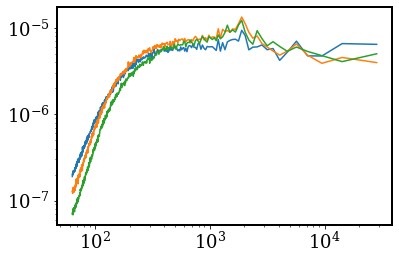

In [170]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#0.1zi
PS_y = spec_power_list_q_1100y_60m
PS_x = spec_power_list_q_1100x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_q_1100y_329m
PS_x = spec_power_list_q_1100x_329m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_q_1100y_650m
PS_x = spec_power_list_q_1100x_650m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


In [171]:
#save the spectral arrays
#0.1zi
np.save('work/scale_analysis/spec_power_list_q_1100y_60m.npy', spec_power_list_q_1100y_60m)
np.save('work/scale_analysis/spec_power_list_q_1100x_60m.npy', spec_power_list_q_1100x_60m)

#0.5zi
np.save('work/scale_analysis/spec_power_list_q_1100y_329m.npy', spec_power_list_q_1100y_329m)
np.save('work/scale_analysis/spec_power_list_q_1100x_329m.npy', spec_power_list_q_1100x_329m)

#zi
np.save( 'work/scale_analysis/spec_power_list_q_1100y_650m.npy', spec_power_list_q_1100y_650m)
np.save( 'work/scale_analysis/spec_power_list_q_1100x_650m.npy', spec_power_list_q_1100x_650m)


I'll also first try redoing the spectra with scipy, periodogram. Try doing this for 0.5 zi

For T

In [180]:
#1100
#T, 60 m
spec_power_list_theta_1100y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','y','2019-08-23T11:00:00.000000000')
spec_power_list_theta_1100x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','x','2019-08-23T11:00:00.000000000')

#1100
#q, 329 m
spec_power_list_theta_1100y_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'theta','y','2019-08-23T11:00:00.000000000')
spec_power_list_theta_1100x_329m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,329,'theta','x','2019-08-23T11:00:00.000000000')

#1100
#q, 650 m
spec_power_list_theta_1100y_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'theta','y','2019-08-23T11:00:00.000000000')
spec_power_list_theta_1100x_650m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,650,'theta','x','2019-08-23T11:00:00.000000000')

[########################################] | 100% Completed | 101.78 ms
[########################################] | 100% Completed | 101.07 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 101.01 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 101.08 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 101.18 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 10

In [181]:
#save the spectral arrays
#0.1zi
np.save('work/scale_analysis/spec_power_list_theta_1100y_60m.npy', spec_power_list_theta_1100y_60m)
np.save('work/scale_analysis/spec_power_list_theta_1100x_60m.npy', spec_power_list_theta_1100x_60m)

#0.5zi
np.save('work/scale_analysis/spec_power_list_theta_1100y_329m.npy', spec_power_list_theta_1100y_329m)
np.save('work/scale_analysis/spec_power_list_theta_1100x_329m.npy', spec_power_list_theta_1100x_329m)

#zi
np.save( 'work/scale_analysis/spec_power_list_theta_1100y_650m.npy', spec_power_list_theta_1100y_650m)
np.save( 'work/scale_analysis/spec_power_list_theta_1100x_650m.npy', spec_power_list_theta_1100x_650m)


/tmp/ipykernel_2020866/3276352325.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/3276352325.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/3276352325.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


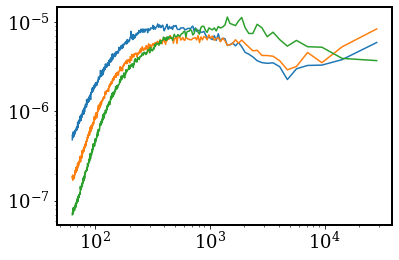

In [182]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#0.1zi
PS_y = spec_power_list_theta_1100y_60m
PS_x = spec_power_list_theta_1100x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_theta_1100y_329m
PS_x = spec_power_list_theta_1100x_329m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_theta_1100y_650m
PS_x = spec_power_list_theta_1100x_650m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


I'm gonna try and checkout what happens at 1200 first.

For q:

In [183]:
#1200
#q, 60 m
spec_power_list_q_1200y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','y','2019-08-23T12:00:00.000000000')
spec_power_list_q_1200x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','x','2019-08-23T12:00:00.000000000')

#1200
#q, 122 m
spec_power_list_q_1200y_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'q','y','2019-08-23T12:00:00.000000000')
spec_power_list_q_1200x_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'q','x','2019-08-23T12:00:00.000000000')

#1200
#q, 610 m
spec_power_list_q_1200y_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'q','y','2019-08-23T12:00:00.000000000')
spec_power_list_q_1200x_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'q','x','2019-08-23T12:00:00.000000000')

#1200
#q, 975 m
spec_power_list_q_1200y_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'q','y','2019-08-23T12:00:00.000000000')
spec_power_list_q_1200x_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'q','x','2019-08-23T12:00:00.000000000')


[########################################] | 100% Completed | 101.44 ms
[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 100.83 ms
[########################################] | 100% Completed | 100.89 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 10

In [184]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_q_1200y_60m.npy', spec_power_list_q_1100y_60m)
np.save('work/scale_analysis/spec_power_list_q_1200x_60m.npy', spec_power_list_q_1100x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_q_1200y_122m.npy', spec_power_list_q_1200y_122m)
np.save('work/scale_analysis/spec_power_list_q_1200x_122m.npy', spec_power_list_q_1200x_122m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_q_1200y_610m.npy', spec_power_list_q_1200y_610m)
np.save('work/scale_analysis/spec_power_list_q_1200x_610m.npy', spec_power_list_q_1200x_610m)

#zi
np.save( 'work/scale_analysis/spec_power_list_q_1200y_975m.npy', spec_power_list_q_1200y_975m)
np.save( 'work/scale_analysis/spec_power_list_q_1200x_975m.npy', spec_power_list_q_1200x_975m)


/tmp/ipykernel_2020866/2068976031.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/2068976031.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/2068976031.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/2068976031.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


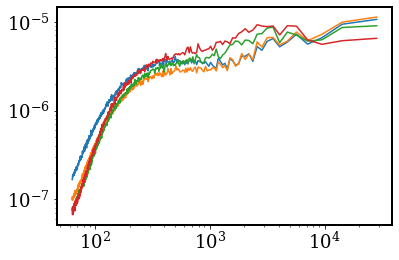

In [185]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_q_1200y_60m
PS_x = spec_power_list_q_1200x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_q_1200y_122m
PS_x = spec_power_list_q_1200x_122m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_q_1200y_610m
PS_x = spec_power_list_q_1200x_610m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_q_1200y_975m
PS_x = spec_power_list_q_1200x_975m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


For theta

In [186]:
#1200
#theta, 60 m
spec_power_list_theta_1200y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','y','2019-08-23T12:00:00.000000000')
spec_power_list_theta_1200x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','x','2019-08-23T12:00:00.000000000')

#1200
#theta, 122 m
spec_power_list_theta_1200y_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'theta','y','2019-08-23T12:00:00.000000000')
spec_power_list_theta_1200x_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'theta','x','2019-08-23T12:00:00.000000000')

#1200
#theta, 610 m
spec_power_list_theta_1200y_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'theta','y','2019-08-23T12:00:00.000000000')
spec_power_list_theta_1200x_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'theta','x','2019-08-23T12:00:00.000000000')

#1200
#theta, 975 m
spec_power_list_theta_1200y_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'theta','y','2019-08-23T12:00:00.000000000')
spec_power_list_theta_1200x_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'theta','x','2019-08-23T12:00:00.000000000')


[########################################] | 100% Completed | 101.46 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.04 ms
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 100.72 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 10

In [187]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_theta_1200y_60m.npy', spec_power_list_theta_1100y_60m)
np.save('work/scale_analysis/spec_power_list_theta_1200x_60m.npy', spec_power_list_theta_1100x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_theta_1200y_122m.npy', spec_power_list_theta_1200y_122m)
np.save('work/scale_analysis/spec_power_list_theta_1200x_122m.npy', spec_power_list_theta_1200x_122m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_theta_1200y_610m.npy', spec_power_list_theta_1200y_610m)
np.save('work/scale_analysis/spec_power_list_theta_1200x_610m.npy', spec_power_list_theta_1200x_610m)

#zi
np.save( 'work/scale_analysis/spec_power_list_theta_1200y_975m.npy', spec_power_list_theta_1200y_975m)
np.save( 'work/scale_analysis/spec_power_list_theta_1200x_975m.npy', spec_power_list_theta_1200x_975m)


/tmp/ipykernel_2020866/55166463.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/55166463.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/55166463.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/55166463.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


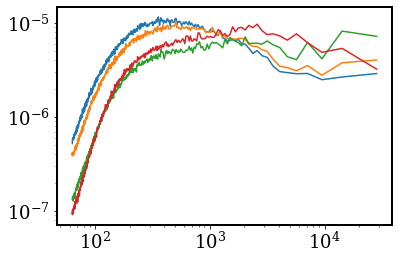

In [188]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_theta_1200y_60m
PS_x = spec_power_list_theta_1200x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_theta_1200y_122m
PS_x = spec_power_list_theta_1200x_122m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_theta_1200y_610m
PS_x = spec_power_list_theta_1200x_610m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_theta_1200y_975m
PS_x = spec_power_list_theta_1200x_975m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


For w

In [189]:
#1200
#w, 60 m
spec_power_list_w_1200y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','y','2019-08-23T12:00:00.000000000')
spec_power_list_w_1200x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','x','2019-08-23T12:00:00.000000000')

#1200
#w, 122 m
spec_power_list_w_1200y_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'w','y','2019-08-23T12:00:00.000000000')
spec_power_list_w_1200x_122m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,122,'w','x','2019-08-23T12:00:00.000000000')

#1200
#w, 610 m
spec_power_list_w_1200y_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'w','y','2019-08-23T12:00:00.000000000')
spec_power_list_w_1200x_610m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,610,'w','x','2019-08-23T12:00:00.000000000')

#1200
#w, 975 m
spec_power_list_w_1200y_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'w','y','2019-08-23T12:00:00.000000000')
spec_power_list_w_1200x_975m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,975,'w','x','2019-08-23T12:00:00.000000000')


[########################################] | 100% Completed | 101.44 ms
[########################################] | 100% Completed | 101.04 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 100.89 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.80 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 10

In [190]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_w_1200y_60m.npy', spec_power_list_w_1200y_60m)
np.save('work/scale_analysis/spec_power_list_w_1200x_60m.npy', spec_power_list_w_1200x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_w_1200y_122m.npy', spec_power_list_w_1200y_122m)
np.save('work/scale_analysis/spec_power_list_w_1200x_122m.npy', spec_power_list_w_1200x_122m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_w_1200y_610m.npy', spec_power_list_w_1200y_610m)
np.save('work/scale_analysis/spec_power_list_w_1200x_610m.npy', spec_power_list_w_1200x_610m)

#zi
np.save( 'work/scale_analysis/spec_power_list_w_1200y_975m.npy', spec_power_list_w_1200y_975m)
np.save( 'work/scale_analysis/spec_power_list_w_1200x_975m.npy', spec_power_list_w_1200x_975m)


/tmp/ipykernel_2020866/3429543461.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/3429543461.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/3429543461.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/3429543461.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


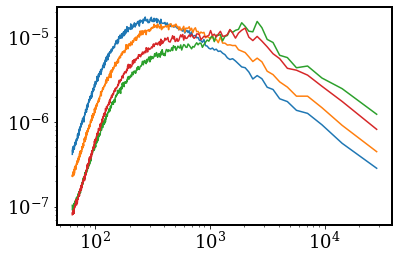

In [191]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_w_1200y_60m
PS_x = spec_power_list_w_1200x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_w_1200y_122m
PS_x = spec_power_list_w_1200x_122m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_w_1200y_610m
PS_x = spec_power_list_w_1200x_610m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_w_1200y_975m
PS_x = spec_power_list_w_1200x_975m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


Same plots for 1400 now!


q

In [192]:
#1400
#q, 60 m
spec_power_list_q_1400y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','y','2019-08-23T14:00:00.000000000')
spec_power_list_q_1400x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'q','x','2019-08-23T14:00:00.000000000')

#1400
#q, 157 m
spec_power_list_q_1400y_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'q','y','2019-08-23T14:00:00.000000000')
spec_power_list_q_1400x_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'q','x','2019-08-23T14:00:00.000000000')

#1400
#q, 784 m
spec_power_list_q_1400y_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'q','y','2019-08-23T14:00:00.000000000')
spec_power_list_q_1400x_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'q','x','2019-08-23T14:00:00.000000000')

#1400
#q, 1254 m
spec_power_list_q_1400y_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'q','y','2019-08-23T14:00:00.000000000')
spec_power_list_q_1400x_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'q','x','2019-08-23T14:00:00.000000000')


[########################################] | 100% Completed | 101.08 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.01 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 101.07 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.01 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 10

In [193]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_q_1400y_60m.npy', spec_power_list_q_1400y_60m)
np.save('work/scale_analysis/spec_power_list_q_1400x_60m.npy', spec_power_list_q_1400x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_q_1400y_157m.npy', spec_power_list_q_1400y_157m)
np.save('work/scale_analysis/spec_power_list_q_1400x_157m.npy', spec_power_list_q_1400x_157m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_q_1400y_784m.npy', spec_power_list_q_1400y_784m)
np.save('work/scale_analysis/spec_power_list_q_1400x_784m.npy', spec_power_list_q_1400x_784m)

#zi
np.save( 'work/scale_analysis/spec_power_list_q_1400y_1254m.npy', spec_power_list_q_1400y_1254m)
np.save( 'work/scale_analysis/spec_power_list_q_1400x_1254m.npy', spec_power_list_q_1400x_1254m)


/tmp/ipykernel_2020866/3902807577.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/3902807577.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2020866/3902807577.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2020866/3902807577.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


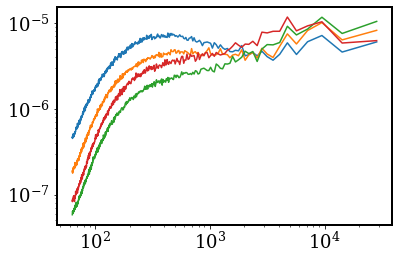

In [194]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_q_1400y_60m
PS_x = spec_power_list_q_1400x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_q_1400y_157m
PS_x = spec_power_list_q_1400x_157m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_q_1400y_784m
PS_x = spec_power_list_q_1400x_784m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_q_1400y_1254m
PS_x = spec_power_list_q_1400x_1254m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


Theta

In [21]:
#1400
#theta, 60 m
spec_power_list_theta_1400y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','y','2019-08-23T14:00:00.000000000')
spec_power_list_theta_1400x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'theta','x','2019-08-23T14:00:00.000000000')

#1400
#theta, 157 m
spec_power_list_theta_1400y_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'theta','y','2019-08-23T14:00:00.000000000')
spec_power_list_theta_1400x_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'theta','x','2019-08-23T14:00:00.000000000')

#1400
#theta, 784 m
spec_power_list_theta_1400y_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'theta','y','2019-08-23T14:00:00.000000000')
spec_power_list_theta_1400x_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'theta','x','2019-08-23T14:00:00.000000000')

#1400
#theta, 1254 m
spec_power_list_theta_1400y_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'theta','y','2019-08-23T14:00:00.000000000')
spec_power_list_theta_1400x_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'theta','x','2019-08-23T14:00:00.000000000')


[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 101.10 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 10

In [22]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_theta_1400y_60m.npy', spec_power_list_theta_1400y_60m)
np.save('work/scale_analysis/spec_power_list_theta_1400x_60m.npy', spec_power_list_theta_1400x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_theta_1400y_157m.npy', spec_power_list_theta_1400y_157m)
np.save('work/scale_analysis/spec_power_list_theta_1400x_157m.npy', spec_power_list_theta_1400x_157m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_theta_1400y_784m.npy', spec_power_list_theta_1400y_784m)
np.save('work/scale_analysis/spec_power_list_theta_1400x_784m.npy', spec_power_list_theta_1400x_784m)

#zi
np.save( 'work/scale_analysis/spec_power_list_theta_1400y_1254m.npy', spec_power_list_theta_1400y_1254m)
np.save( 'work/scale_analysis/spec_power_list_theta_1400x_1254m.npy', spec_power_list_theta_1400x_1254m)


/tmp/ipykernel_2202491/3037294978.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2202491/3037294978.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2202491/3037294978.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2202491/3037294978.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


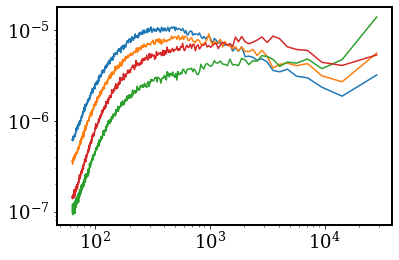

In [23]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_theta_1400y_60m
PS_x = spec_power_list_theta_1400x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_theta_1400y_157m
PS_x = spec_power_list_theta_1400x_157m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_theta_1400y_784m
PS_x = spec_power_list_theta_1400x_784m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_theta_1400y_1254m
PS_x = spec_power_list_theta_1400x_1254m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


w

In [24]:
#1400
#w, 60 m
spec_power_list_w_1400y_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','y','2019-08-23T14:00:00.000000000')
spec_power_list_w_1400x_60m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,60,'w','x','2019-08-23T14:00:00.000000000')

#1400
#w, 157 m
spec_power_list_w_1400y_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'w','y','2019-08-23T14:00:00.000000000')
spec_power_list_w_1400x_157m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,157,'w','x','2019-08-23T14:00:00.000000000')

#1400
#w, 784 m
spec_power_list_w_1400y_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'w','y','2019-08-23T14:00:00.000000000')
spec_power_list_w_1400x_784m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,784,'w','x','2019-08-23T14:00:00.000000000')

#1400
#w, 1254 m
spec_power_list_w_1400y_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'w','y','2019-08-23T14:00:00.000000000')
spec_power_list_w_1400x_1254m = spec_power_hzntl(ensemble_member_ds_2_N02_inst,1254,'w','x','2019-08-23T14:00:00.000000000')


[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 100.89 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 10

In [25]:
#save the spectral arrays

#surface
np.save('work/scale_analysis/spec_power_list_w_1400y_60m.npy', spec_power_list_w_1400y_60m)
np.save('work/scale_analysis/spec_power_list_w_1400x_60m.npy', spec_power_list_w_1400x_60m)


#0.1zi
np.save('work/scale_analysis/spec_power_list_w_1400y_157m.npy', spec_power_list_w_1400y_157m)
np.save('work/scale_analysis/spec_power_list_w_1400x_157m.npy', spec_power_list_w_1400x_157m)


#0.5zi
np.save('work/scale_analysis/spec_power_list_w_1400y_784m.npy', spec_power_list_w_1400y_784m)
np.save('work/scale_analysis/spec_power_list_w_1400x_784m.npy', spec_power_list_w_1400x_784m)

#zi
np.save( 'work/scale_analysis/spec_power_list_w_1400y_1254m.npy', spec_power_list_w_1400y_1254m)
np.save( 'work/scale_analysis/spec_power_list_w_1400x_1254m.npy', spec_power_list_w_1400x_1254m)


/tmp/ipykernel_2202491/4099271859.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2202491/4099271859.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.1zi')
/tmp/ipykernel_2202491/4099271859.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = '0.5zi')
/tmp/ipykernel_2202491/4099271859.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/freq,spec_power*freq, label = 'zi')


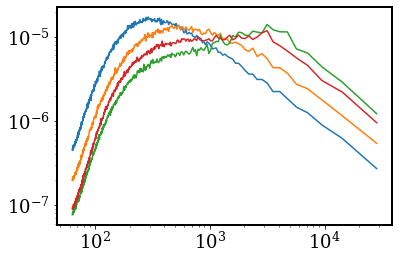

In [26]:
#averaging the spectral powers in x and y,
freq_y = fft.fftfreq(int(Ly))[0:int(Ny/2)]
freq_x = fft.fftfreq(int(Lx))[0:int(Nx/2)]

#surface
PS_y = spec_power_list_w_1400y_60m
PS_x = spec_power_list_w_1400x_60m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')


#0.1zi
PS_y = spec_power_list_w_1400y_157m
PS_x = spec_power_list_w_1400x_157m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)
freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.1zi')

#0.5zi
PS_y = spec_power_list_w_1400y_784m
PS_x = spec_power_list_w_1400x_784m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = '0.5zi')

#zi
PS_y = spec_power_list_w_1400y_1254m
PS_x = spec_power_list_w_1400x_1254m

spec_power = (PS_y[:450] + PS_x)/2
spec_power = spec_power/np.sum(spec_power)

freq = np.sqrt((freq_y[:450]**2 + freq_x**2)/2)

plt.loglog(1/freq,spec_power*freq, label = 'zi')


I'm gonna start with the 1400 w data

In [64]:
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

In [65]:
ensemble_member_ds_2_N02_inst = open_concat_member_files(2,'DATA_3D_NETCDF_N02slice','iop02')


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.278148852288723 seconds


In [70]:
w_data = ensemble_member_ds_2_N02_inst.w.sel(time='2019-08-23T11:00:00.000000000',zw_3d=60,method='nearest').values


[########################################] | 100% Completed | 101.51 ms


In [71]:
#reshape into a square
w_data_sq = w_data[108:,:]

[########################################] | 100% Completed | 101.24 ms


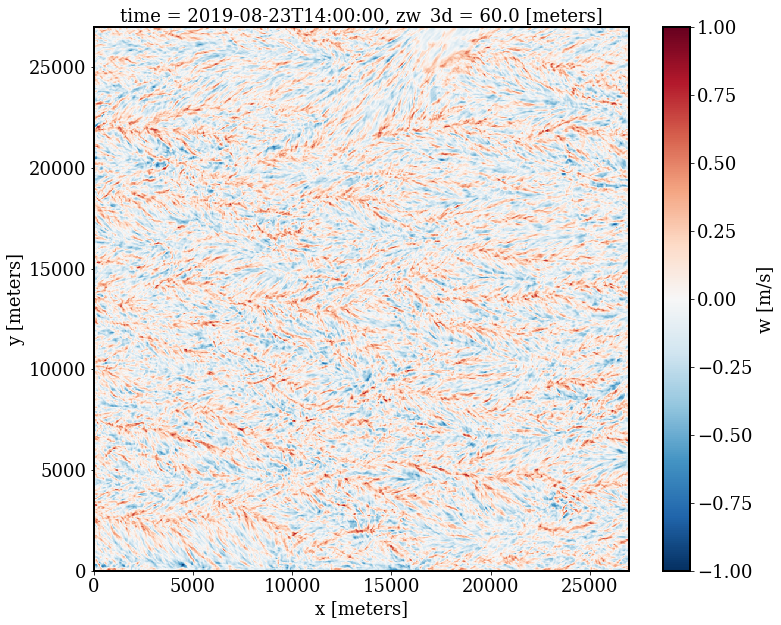

In [72]:
#check the plot
ensemble_member_ds_2_N02.w.sel(time='2019-08-23T14:00:00.000000000',zw_3d=60,method='nearest').isel(y=slice(None,900)).plot(vmin=-1,vmax=1,cmap='RdBu_r',figsize=(12,10))

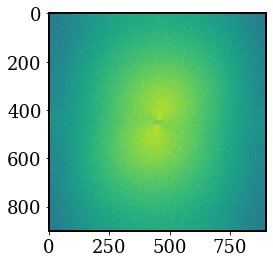

In [77]:
#take the fft!
PS2D = fft.fftn(w_data_sq)
plt.imshow(np.log(np.abs(fft.fftshift(PS2D))**2))



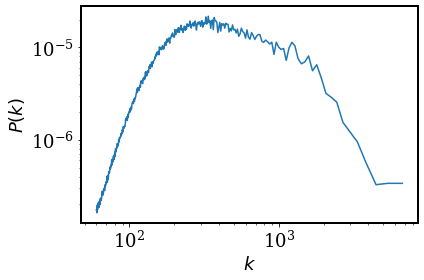

In [75]:
#k53 = (spatial_freq**(-2/3))
PSD2D = np.abs(fft.fftshift(PS2D))**2
PSD1D = GetPSD1D(PSD2D)

spatial_freq = (fft.rfftfreq(900,30))[1:]
plt.figure(figsize=(6,4))
plt.loglog(1/spatial_freq[3:], (PSD1D/np.sum(PSD1D)*spatial_freq)[3:])
#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()


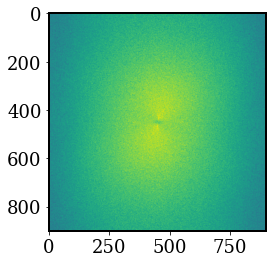

In [81]:
#take the fft!
PS2D = fft.fftn(windowed_velocity)
plt.imshow(np.log(np.abs(fft.fftshift(PS2D))**2))



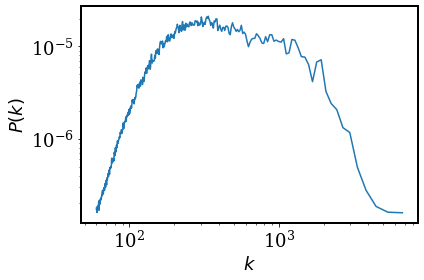

In [82]:
#k53 = (spatial_freq**(-2/3))

PSD2D = np.abs(fft.fftshift(PS2D))**2
PSD1D = GetPSD1D(PSD2D)

spatial_freq = (fft.rfftfreq(900,30))[1:]
plt.figure(figsize=(6,4))
plt.loglog(1/spatial_freq[3:], (PSD1D/np.sum(PSD1D)*spatial_freq)[3:])
#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()


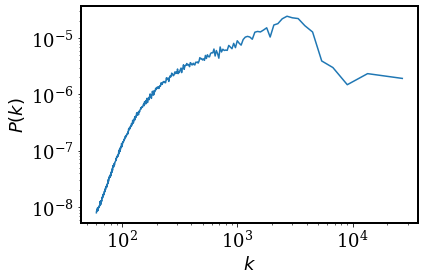

In [94]:
#k53 = (spatial_freq**(-2/3))
PSD2D = np.abs(fft.fftshift(PS2D))**2
PSD1D = GetPSD1D(PSD2D)

spatial_freq = (fft.rfftfreq(900,30))[1:]
plt.loglog(1/spatial_freq, PSD1D*spatial_freq/np.sum(PSD1D))
#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()


In [99]:
PSD1D.shape

(450,)

Let me see if i can do a spectogram from 60 till 1254 m 

In [98]:
time_step = '2019-08-23T14:00:00.000000000'
#zi = 657 #1100
zi = 1568 #1400
#height_array = ensemble_member_ds_2_N02_inst.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,0.8*zi)).values 
height_array = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []
for height in height_array:
    #print(height)
    #w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height,method='nearest').values
    w_data = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step,zu_3d=height,method='nearest').values
    w_data = w_data - np.mean(w_data)
    #reshape into a square
    #cutting off the southernmost parts
    w_data_sq = w_data[108:,:]
    #take the fft!
    fourier_amps = fft.fftn(w_data_sq)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs(fft.fftshift(fourier_amps))**2
    #for temp.
    PS1D = GetPSD1D(PS2D)[5:]
    #PS_array = PS1D
    PS_array.append(PS1D/np.sum(PS1D))
    
PS_array = np.asarray(PS_array)    
spatial_freq = (fft.rfftfreq(w_data_sq.shape[0],30))[1:]
spatial_freq = spatial_freq[5:]

[########################################] | 100% Completed | 101.58 ms
[########################################] | 100% Completed | 101.40 ms
[########################################] | 100% Completed | 101.32 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 101.51 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 10

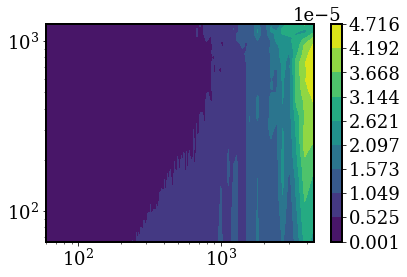

In [99]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])
plt.colorbar(im)
#plt.show()


In [26]:
(PS_array*spatial_freq)[0].shape

(445,)

Redoing this with a hanning filter for the edges

In [100]:
time_step = '2019-08-23T14:00:00.000000000'
#zi = 657 #1100
zi = 1568 #1400
#height_array = ensemble_member_ds_2_N02_inst.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,0.8*zi)).values 
height_array = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []
for height in height_array:
    #print(height)
    #w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height,method='nearest').values
    w_data = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step,zu_3d=height,method='nearest').values
    w_data = w_data - np.mean(w_data)
    #reshape into a square
    #cutting off the southernmost parts
    w_data_sq = w_data[108:,:]
    Nx = w_data_sq.shape[0]
    Ny = w_data_sq.shape[1]
    windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)
    #take the fft!
    fourier_amps = fft.fftn(windowed_data)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs(fft.fftshift(fourier_amps))**2
    #for temp.
    PS1D = GetPSD1D(PS2D)[5:]
    #PS_array = PS1D
    PS_array.append(PS1D/np.sum(PS1D))
    
PS_array = np.asarray(PS_array)    
spatial_freq = (fft.rfftfreq(windowed_data.shape[0],30))[1:]
spatial_freq = spatial_freq[5:]

[########################################] | 100% Completed | 101.71 ms
[########################################] | 100% Completed | 101.38 ms
[########################################] | 100% Completed | 101.54 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.25 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 101.32 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.50 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 10

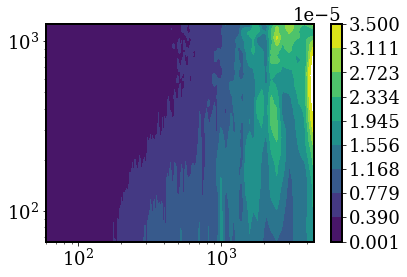

In [109]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), 3.5*10**-5, 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])
plt.colorbar(im)
#plt.show()


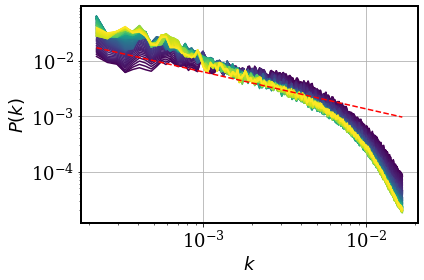

In [110]:
heights = 100
colors = plt.cm.viridis(np.linspace(0,1,heights))
fig, ax = plt.subplots()
for i in np.arange(heights):
    spectra = (PS_array*spatial_freq)[i]
    plt.loglog(spatial_freq, spectra/np.sum(spectra),color=colors[i])
    #plt.loglog(1/spatial_freq, k53/np.sum(k53))
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
plt.loglog(spatial_freq, spatial_freq**(-2/3)/np.sum(spatial_freq**(-2/3)),'--',color='red')
ax.grid(True)


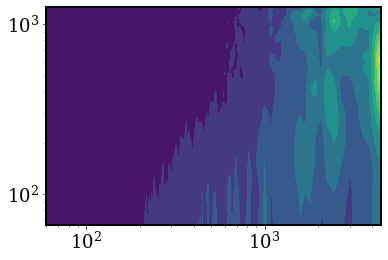

In [111]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])

#plt.show()


Try and calculate the cospectra for wtheta

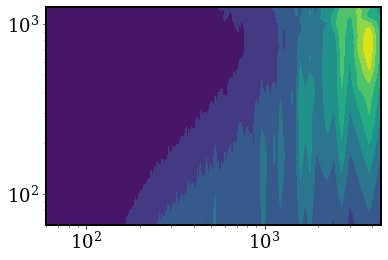

In [18]:
# make data
#wtheta cospectra
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])

#plt.show()


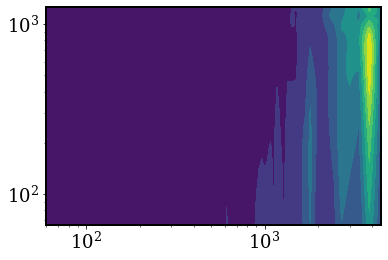

In [271]:
# make data
#wtheta cospectra, dispersive
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])

#plt.show()


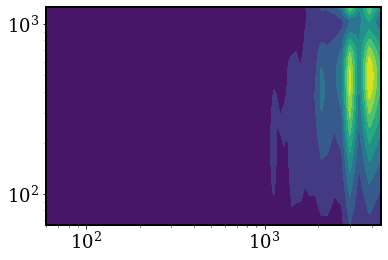

In [289]:
#wtheta dispersive, normalised by surface covariance
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])

#plt.show()


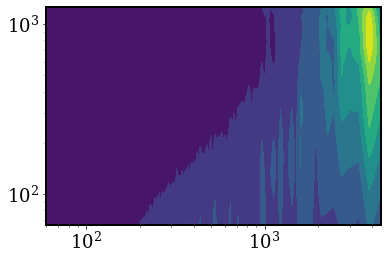

In [49]:
# wq cospectra
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(X, Y, Z, levels=levels)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])

#plt.show()


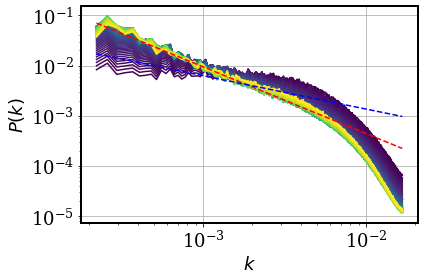

In [52]:
heights = 100
colors = plt.cm.viridis(np.linspace(0,1,heights))
fig, ax = plt.subplots()
for i in np.arange(heights):
    spectra = (PS_array*spatial_freq)[i]
    plt.loglog(spatial_freq, spectra/np.sum(spectra),color=colors[i])
    #plt.loglog(1/spatial_freq, k53/np.sum(k53))
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
plt.loglog(spatial_freq, spatial_freq**(-4/3)/np.sum(spatial_freq**(-4/3)),'--',color='red')
plt.loglog(spatial_freq, spatial_freq**(-2/3)/np.sum(spatial_freq**(-2/3)),'--',color='blue')
ax.grid(True)


In [36]:
ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height).values

[########################################] | 100% Completed | 101.52 ms


array([[ 0.93360114,  1.0744915 ,  0.8690055 , ...,  0.57101184,
         0.50920856,  0.49420503],
       [ 1.0505418 ,  1.1735536 ,  0.79698676, ...,  0.5349673 ,
         0.45692784,  0.46412778],
       [ 1.237294  ,  1.2249559 ,  0.59122825, ...,  0.44125375,
         0.431379  ,  0.51713735],
       ...,
       [ 0.5087264 ,  0.2040199 , -0.3722488 , ..., -0.40966174,
        -0.34546876, -0.28798705],
       [-0.03927087, -0.15265046, -0.261517  , ..., -0.39355645,
        -0.34696597, -0.30698755],
       [ 0.17392695,  0.17406444,  0.19414866, ..., -0.3325694 ,
        -0.2789752 , -0.2620923 ]], dtype=float32)

In [55]:
time_step = '2019-08-23T14:00:00.000000000'
#zi = 657 #1100
zi = 1568 #1400
ensemble_member_ds_2_N02_inst = open_concat_member_files(8,'DATA_3D_NETCDF_N02slice','iop02')
height_array = ensemble_member_ds_2_N02_inst.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,0.8*zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []
for height in height_array:
    #print(height)
    #w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height,method='nearest').values
    w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height).values
    #w_data = ensemble_member_ds_2_N02_inst.q.sel(time=time_step,zu_3d=height,method='nearest').values*1000
    w_data = w_data - np.mean(w_data)
    #reshape into a square
    #cutting off the southernmost parts
    w_data_sq = w_data[108:,:]
    #take the fft!
    fourier_amps = fft.fftn(w_data_sq)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs(fft.fftshift(fourier_amps))**2
    #for temp.
    PS1D = GetPSD1D(PS2D)[5:]
    #PS_array = PS1D
    PS_array.append(PS1D/np.sum(PS1D))
    
PS_array = np.asarray(PS_array)    
spatial_freq = (fft.rfftfreq(w_data_sq.shape[0],30))[1:]
spatial_freq = spatial_freq[5:]

['04.ches_IOP2.1455', '05. ches_IOP2.31525', '06.ches_IOP2.1409', '07.ches_IOP2.31095', '1.ches_IOP2.11058', '2.ches_IOP2.20781', '3.ches_IOP2.1521']
Member 8 finished collecting data
Done with member 8  Time elapsed  2.6267167071346194 seconds
[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 101.55 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 101.32 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.35 ms
[##################################

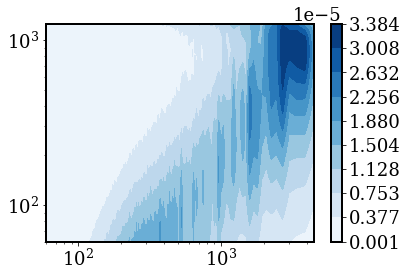

In [23]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels,cmap='Blues')
#im = ax.contour(X, Y, Z, levels=levels)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])
plt.colorbar(im)
#plt.show()


In [56]:
#PS_array_1 = PS_array
#PS_array_2 = PS_array
# PS_array_3 = PS_array
# PS_array_4 = PS_array
#PS_array_5 = PS_array
# PS_array_6 = PS_array
# PS_array_7 = PS_array
#PS_array_8 = PS_array

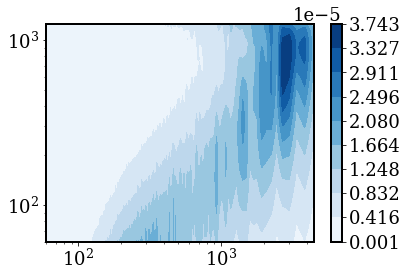

In [57]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels,cmap='Blues')
#im = ax.contour(X, Y, Z, levels=levels)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])
plt.colorbar(im)
#plt.show()


In [62]:
PS_array_mean= (PS_array_1+PS_array_2+PS_array_3+PS_array_4+PS_array_5+PS_array_6+PS_array_7+PS_array_8)/8

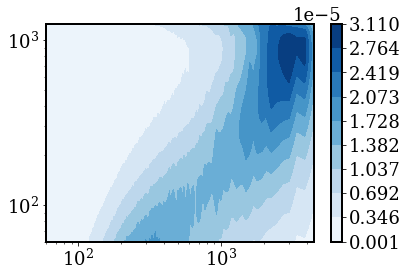

In [63]:
# make data
X, Y = np.meshgrid(1/spatial_freq, height_array)
Z = (PS_array_mean*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels,cmap='Blues')
#im = ax.contour(X, Y, Z, levels=levels)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0,10000])
plt.colorbar(im)
#plt.show()


I'll continue doing this 

In [21]:
iop = 'iop03'
fname = 'DATA_3D_NETCDF_N02slice'

#member_num = np.arange(1,9) #iop02
member_num = np.arange(0,8) #iop03

#time_step = '2019-08-23T11:00:00.000000000'
#time_step = '2019-08-23T12:00:00.000000000'
#time_step = '2019-08-23T14:00:00.000000000'

time_step = '2019-09-24T11:00:00.000000000'
#time_step = '2019-09-24T12:00:00.000000000'
#time_step = '2019-09-24T13:00:00.000000000'

#zi = 657 #1100, iop02
#zi = 1219 #1200, iop02
#zi = 1568 #1400, iop02

zi = 382 #1100, iop03
#zi = 608 #1200, iop03
#zi = 701#1300, iop03

#var = 'w'

In [22]:
PS_array_ensemble = []
for member in member_num:    
    
    ensemble_member_ds_2_N02_inst = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)
    
    #height_array = ensemble_member_ds_2_N02_inst.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,zi)).values 
    #height_array = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,zi)).values 
    height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,zi)).values 
    
    PS_array = []
    for height in height_array:
        
        #data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height).values
        #data = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step,zu_3d=height).values
        data = ensemble_member_ds_2_N02_inst.q.sel(time=time_step,zu_3d=height).values*1000
        
        data = data - np.mean(data)
        #reshape into a square
        #cutting off the southernmost parts
        data_sq = data[108:,:]
        
        #apply a hanning window
        Nx = data_sq.shape[0]
        Ny = data_sq.shape[1]        
        windowed_data = data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

        #take the fft!
        fourier_amps = fft.fftn(windowed_data)

        #k53 = (spatial_freq**(-2/3))
        PS2D = np.abs(fft.fftshift(fourier_amps))**2
        #for temp.
        PS1D = GetPSD1D(PS2D)[3:]
        #PS_array = PS1D
        # PSD1D = PS1D*spatial_freq
        
        PS_array.append(PS1D/np.sum(PS1D))

    PS_array = np.asarray(PS_array)
    PS_array_ensemble.append(PS_array)

spatial_freq = (fft.rfftfreq(windowed_data.shape[0],30))[1:]
spatial_freq = spatial_freq[3:]



['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  3.5224322751164436 seconds
[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.24 ms
[########################################] | 100% Completed | 101.40 ms
[###########

In [23]:
PS_array_ensemble = np.asarray(PS_array_ensemble)
PS_array_ensemble_mean = np.mean(PS_array_ensemble,axis=0)

In [24]:

#change file name before saving

np.save('work/scale_analysis/spectrograms/PS_q_iop03_1100_insta.npy', PS_array_ensemble_mean)

Load data if needed

In [29]:

#change file name before loading

PS_array_ensemble_mean = np.load('work/scale_analysis/spectrograms/PS_w_iop03_1100_insta.npy')

data_ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)

height_array = data_ds.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,zi)).values 
#height_array = data_ds.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,zi)).values 

data = data_ds.w.sel(time=time_step,zw_3d=60).values
#data = data_ds.q.sel(time=time_step,zu_3d=height_array[0]).values*1000
data = data - np.mean(data)
#reshape into a square
#cutting off the southernmost parts
data_sq = data[108:,:]
#apply a hanning window
Nx = data_sq.shape[0]
Ny = data_sq.shape[1]        
windowed_data = data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

        
spatial_freq = (fft.rfftfreq(windowed_data.shape[0],30))[1:]
spatial_freq = spatial_freq[3:]


['1_ches_IOP3.20410', '2_ches_IOP3.25917', '3_ches_IOP3.2034', '4_ches_IOP3.21467', '5_ches_IOP3.32727', '6_ches_IOP3.3552', '7_ches_IOP3.31219', '8_ches_IOP3.27773']
Member 7 finished collecting data
Done with member 7  Time elapsed  0.307234900072217 seconds
[########################################] | 100% Completed | 101.21 ms


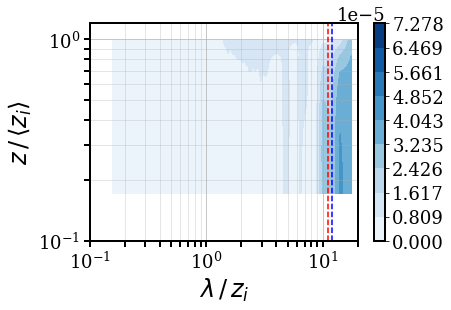

In [27]:

X, Y = np.meshgrid((1/spatial_freq)/zi, height_array/zi)
Z = (PS_array_ensemble_mean*spatial_freq)

#levels = np.linspace(np.min(Z), np.max(Z), 10)#7.278
levels = np.linspace(np.min(Z), 7.278e-05, 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z,levels=levels,cmap='Blues')

# # #1100, iop02
# plt.axvline(x = 4352/zi, linestyle='--',color='red')
# plt.axvline(x = 5290/zi, linestyle='--',color='blue')

#1400, iop02
# plt.axvline(x = 4377/zi, linestyle='--',color='red')
# plt.axvline(x = 4987/zi, linestyle='--',color='blue')

#1100, iop03
plt.axvline(x = 4287/zi, linestyle='--',color='red')
plt.axvline(x = 4633/zi, linestyle='--',color='blue')

# # 1300, iop03
# plt.axvline(x = 4453/zi, linestyle='--',color='red')
# plt.axvline(x = 4655/zi, linestyle='--',color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim([0.1,1.2])#iop02, 1100
#ax.set_ylim([0.04,1.2])#iop02. 1400

#ax.set_xlim([None,10])#iop02
ax.set_xlim([0.1,20])#iop03

ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)
#ax.tick_params(width=2, length=4)
ax.tick_params(which = 'both',width=2, length=6)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.9)
plt.colorbar(im)

output_fname = 'work/scale_analysis/plots/IOP03_q_1100.png'
plt.savefig(output_fname,dpi=300, bbox_inches="tight")



In [92]:
#i'm going to convert spectral amplitude to variance and plot ok, first
#then normalise by the surface (co)variance values

In [238]:
w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=600,method='nearest').values
#w_data = ensemble_member_ds_2_N02_inst.q.sel(time=time_step,zu_3d=height,method='nearest').values*1000
w_data = w_data - np.mean(w_data)
#reshape into a square
#cutting off the southernmost parts
w_data_sq = w_data[108:,:]
#take the fft!
fourier_amps = fft.fftn(w_data_sq)

#k53 = (spatial_freq**(-2/3))
PS2D = np.abs(fft.fftshift(fourier_amps))**2

#for temp.
PS1D = GetPSD1D(PS2D)#[5:]
spatial_freq = (fft.rfftfreq(w_data_sq.shape[0],30))[1:]
PSD1D = PS1D*spatial_freq


[########################################] | 100% Completed | 101.46 ms


In [233]:
spatial_freq.shape

(450,)

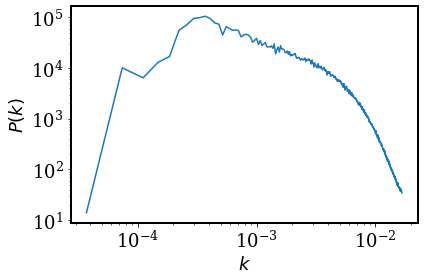

In [234]:
plt.loglog(spatial_freq, PSD1D)
#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()


In [246]:
var = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=600,method='nearest').isel(y=slice(108,None)).var().values
var

[########################################] | 100% Completed | 101.66 ms


array(1.6792092, dtype=float32)

In [223]:
(var/899/899)*900*900

0.8096112445463135

The sum of spectral energies should be equal to this

In [239]:
PSD1D.shape

(450,)

In [245]:
#the calculated fourier amplitudes are:
np.sum(PSD1D*2/900**2)

16.61144797054726

##### Normalise by surface covariance

In [268]:
time_step = '2019-08-23T14:00:00.000000000'
ensemble_member_ds_2_N02_inst = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')

ds = ensemble_member_ds_2_N02_inst.sel(time=time_step)
ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).compute()
#ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).compute()


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3187355319969356 seconds
[########################################] | 100% Completed | 21.69 ss


In [288]:
#zi = 657 #1100
zi = 1568 #1400
#height_array = ensemble_member_ds_2_N02_inst.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,0.8*zi)).values 
height_array = ensemble_member_ds_2_N02_inst.theta.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 

w_data = ds.w.sel(zw_3d=60,method='nearest').values
theta_data = ds.theta_interpolated.sel(zw_3d=60,method='nearest').values

w_data_sq = w_data[108:,:]
w_data_sq = w_data_sq - np.mean(w_data_sq)

theta_data_sq = theta_data[108:,:]
theta_data_sq = theta_data_sq - np.mean(theta_data_sq)

surf_cov = np.mean(np.multiply(w_data_sq,theta_data_sq))

PS_array = []
for height in height_array:
    #print(height)
    w_data = ds.w.sel(zw_3d=height,method='nearest').values
    theta_data = ds.theta_interpolated.sel(zw_3d=height,method='nearest').values
    #q_data = ds.q_interpolated.sel(zw_3d=height,method='nearest').values
    #reshape into a square
    #cutting off the southernmost parts
    w_data_sq = w_data[108:,:]
    w_data_sq = w_data_sq - np.mean(w_data_sq)
    
    theta_data_sq = theta_data[108:,:]
    theta_data_sq = theta_data_sq - np.mean(theta_data_sq)
    #q_data_sq = q_data[108:,:]
    
    #take the fft!
    fourier_amps_w = fft.fftn(w_data_sq)
    fourier_amps_theta = fft.fftn(theta_data_sq)
    #fourier_amps_q = fft.fftn(q_data_sq)

    #k53 = (spatial_freq**(-2/3))
    #PS2D = np.abs(fft.fftshift(fourier_amps_w)*np.conj(fft.fftshift(fourier_amps_q)))
    PS2D = np.abs(fft.fftshift(fourier_amps_w)*np.conj(fft.fftshift(fourier_amps_theta)))
    #for temp.
    PS1D = GetPSD1D(PS2D)[5:]
    #PS_array = PS1D
    #normalize and convert to variance
    PS1D_normalised =  ((PS1D*(2/900**2))/10)/surf_cov
    PS_array.append(PS1D_normalised)
    
PS_array = np.asarray(PS_array)    
spatial_freq = (fft.rfftfreq(w_data_sq.shape[0],30))[1:]
spatial_freq = spatial_freq[5:]

[########################################] | 100% Completed | 102.02 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.53 ms
[########################################] | 100% Completed | 101.46 ms
[########################################] | 100% Completed | 101.18 ms
[########################################] | 100% Completed | 101.49 ms
[########################################] | 100% Completed | 101.62 ms
[########################################] | 100% Completed | 101.46 ms
[########################################] | 100% Completed | 101.20 ms
[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 101.51 ms
[########################################] | 100% Completed | 10

In [47]:
#got to first calculate w_hi and theta_hi

iop = 'iop03'
fname = 'DATA_3D_NETCDF_N02slice'

#member_num = np.arange(1,9) #iop02
member_num = np.arange(0,8) #iop03

#time_step = '2019-08-23T11:00:00.000000000'
#time_step = '2019-08-23T12:00:00.000000000'
#time_step = '2019-08-23T14:00:00.000000000'

time_step = '2019-09-24T11:00:00.000000000'
#time_step = '2019-09-24T12:00:00.000000000'
#time_step = '2019-09-24T13:00:00.000000000'

#zi = 657 #1100, iop02
#zi = 1219 #1200, iop02
#zi = 1568 #1400, iop02

zi = 382 #1100, iop03
#zi = 608 #1200, iop03
#zi = 701#1300, iop03

#var = 'w'

Instantaneous values, ensemble mean cospectra

In [48]:
PS_array_ensemble = []
for member in member_num:    
    ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop).sel(time=time_step)
    #interpolate theta and q to the same grid
    #ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).compute()
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).compute()

    height_array = ds.zw_3d.sel(zw_3d=slice(60,zi)).values 
    #height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
    PS_array = []
    for height in height_array:
        #print(height)
        #w_data = ensemble_member_ds_2_N02_inst.w.sel(time=time_step,zw_3d=height,method='nearest').values
        w_data = ds.w.sel(zw_3d=height,method='nearest').values
        #var_data = ds.theta_interpolated.sel(zw_3d=height,method='nearest').values
        var_data = ds.q_interpolated.sel(zw_3d=height,method='nearest').values*1000
        #reshape into a square
        #cutting off the southernmost parts
        w_data_sq = w_data[108:,:]
        var_data_sq = var_data[108:,:]

        #apply a hanning window
        Nx = w_data_sq.shape[0]
        Ny = w_data_sq.shape[1]        
        w_windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)
        var_windowed_data = var_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

        
        #take the fft!
        fourier_amps_w = fft.fftn(w_windowed_data)
        fourier_amps_var = fft.fftn(var_windowed_data)

        #k53 = (spatial_freq**(-2/3))
        PS2D = np.abs(fft.fftshift(fourier_amps_w)*np.conj(fft.fftshift(fourier_amps_var)))
        #for temp.
        PS1D = GetPSD1D(PS2D)[3:]
        #PS_array = PS1D
        PS_array.append(PS1D/np.sum(PS1D))

    PS_array = np.asarray(PS_array)
    PS_array_ensemble.append(PS_array)

spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
spatial_freq = spatial_freq[3:]

['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.7022144552320242 seconds
[########################################] | 100% Completed | 19.55 ss
[########################################] | 100% Completed | 101.05 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.48 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.31 ms
[############

In [49]:
PS_array_ensemble = np.asarray(PS_array_ensemble)
PS_array_ensemble_mean = np.mean(PS_array_ensemble,axis=0)

In [50]:
np.save( 'work/scale_analysis/spectrograms/PS_wq_iop03_1100_inst.npy', PS_array_ensemble_mean)



In [31]:

#change file name before loading

PS_array_ensemble_mean = np.load('work/scale_analysis/spectrograms/PS_wtheta_iop02_1100_inst.npy')

member = 2
data_ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)

height_array = data_ds.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,zi)).values 

w_data = data_ds.w.sel(time=time_step,zw_3d=60).values
w_data = w_data - np.mean(w_data)
#reshape into a square
#cutting off the southernmost parts
w_data_sq = w_data[108:,:]
#apply a hanning window
Nx = w_data_sq.shape[0]
Ny = w_data_sq.shape[1]        
w_windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
spatial_freq = spatial_freq[3:]

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2760450206696987 seconds
[########################################] | 100% Completed | 101.20 ms


#### Gonna do wtheta_hi and wq_hi cospectrograms now

Do only for 1100 aug. IOP. 1200 Sep IOP.

1100 23 Aug:

In [39]:
#got to first calculate w_hi and theta_hi

iop = 'iop02'
fname = 'DATA_3D_AV_NETCDF_N02slice'

member_num = np.arange(1,9) #iop02
time_index = 10

time_step = IOP02_time_array[time_index]
print(time_step)
#time_step = '2019-08-23T12:00:00.000000000'
#time_step = '2019-08-23T14:00:00.000000000'

zi = zi_iop02[time_index] #1100, iop02


2019-08-23T14:00:00.000000000


In [40]:

data_list = []
#loop through the member list to select the 3D var value at the time step from each member
for member in member_num:
    #following line of code will concatenate all the data files of input_fname from member_num
    #and select the var at time sim_time
    ds = open_concat_member_files(member,fname,iop).sel(time=time_step)[['w','theta','q']]
    # #subset for the smaller domain
    # ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    #subset for the abl height
    ds = ds.sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    
    #append the data to the list
    data_list.append(ds)


ensemble_ds = xr.concat(data_list,'ensemble')    
print('Calculating hi datasets..')
print('w_hi..')
#hi datasets

w_ensemble_time_mean = ensemble_ds.w.mean('ensemble')
w_space_time_mean = ensemble_ds.w.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
w_hi = (w_ensemble_time_mean - w_space_time_mean).compute()

print('theta_hi..')
theta_ensemble_time_mean = ensemble_ds.theta.mean('ensemble')
theta_space_time_mean = ensemble_ds.theta.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
theta_hi = (theta_ensemble_time_mean - theta_space_time_mean).compute()
theta_hi_interpolated = theta_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)
print('q_hi..')
#calculate spatial_mean(wq_hi)
q_ensemble_time_mean = ensemble_ds.q.mean('ensemble')
q_space_time_mean = ensemble_ds.q.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
q_hi = (q_ensemble_time_mean - q_space_time_mean).compute()
q_hi_interpolated = q_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.37356000393629074 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.31692060083150864 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.3162595294415951 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.31

In [23]:
def sine_taper(n):
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    return np.asarray(W)

spectra for w_hi,q_hi,theta_hi

In [87]:
mean_wind_dir_degrees_list = [ 25.1624835 ,  18.75041802,   8.102142  ,   8.89602428,
        14.24730503,  16.02565065,  13.37958926,   6.69618812,
         2.57431922,   6.51778016,  -1.47654069, -20.7259512 ,
       -27.05573339, -26.00877809, -33.35672462]

In [88]:
wind_angle = 180+np.asarray(mean_wind_dir_degrees_list) #at 11 for iop02, u and v are negative, so wind angle = 180+cartesian angle


In [49]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array_x = []
PS_array_y = []
rotating_factor = 1000000
#var = w_hi
#var = theta_hi_interpolated
var = q_hi_interpolated
for height in height_array:
    #print(height)
    #rotate to the mean wind and subset to the smaller domain
    var_cross_section = var.sel(zw_3d=height,method='nearest').values    
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]
     
    x = ds_2_het_iop02.x.values
    y = ds_2_het_iop02.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x = var_data[yloc,:]-var_data[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        data_x_bt = belltaper(data_x,Nx)     
        data_y_bt = belltaper(data_y,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt)**2)[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt)**2)[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/w_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/w_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/theta_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/theta_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/q_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/q_star_iop02[time_index]**2)


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)


cospectra code:

In [37]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array_x = []
PS_array_y = []
rotating_factor = 1000000
#var = w_hi
#var = theta_hi_interpolated
var = q_hi_interpolated
for height in height_array:
    #print(height)
    #rotate to the mean wind and subset to the smaller domain
    w_cross_section = w_hi.sel(zw_3d=height,method='nearest').values    
    var_cross_section = var.sel(zw_3d=height,method='nearest').values    
    
    w_data = rotate_var(w_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]
     
    x = ds_2_het_iop02.x.values
    y = ds_2_het_iop02.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y_w = w_data[:,xloc]-w_data[:,xloc].mean()
        data_x_w = w_data[yloc,:]-w_data[yloc,:].mean()

        data_y_var = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x_var = var_data[yloc,:]-var_data[yloc,:].mean()


        # #-- apply bell taper to space series
        data_x_bt_w = belltaper(data_x_w,Nx)     
        data_y_bt_w = belltaper(data_y_w,Ny)

        data_x_bt_var = belltaper(data_x_var,Nx)     
        data_y_bt_var = belltaper(data_y_var,Ny)

        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt_w)*np.conj(fftpack.fft(data_x_bt_var)))[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt_w)*np.conj(fftpack.fft(data_y_bt_var)))[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/(w_star_iop02[time_index]*w_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*w_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*theta_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*theta_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*q_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*q_star_iop02[time_index]))


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)


In [123]:
# np.save( 'work/scale_analysis/spectrograms/v20240618/PS_w_x_iop02_1100_hi.npy', PS_array_x)
# np.save( 'work/scale_analysis/spectrograms/v20240618/PS_w_y_iop02_1100_hi.npy', PS_array_y)

load data if needed

In [26]:

# #change file name before loading

# PS_array = np.load('work/scale_analysis/spectrograms/PS_wq_iop02_1400_hi.npy')

# member = 2
# data_ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)

# height_array = data_ds.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(30,zi)).values 

# w_data = data_ds.w.sel(time=time_step,zw_3d=60).values
# w_data = w_data - np.mean(w_data)
# #reshape into a square
# #cutting off the southernmost parts
# w_data_sq = w_data[108:,:]

# #apply a hanning window
# Nx = w_data_sq.shape[0]
# Ny = w_data_sq.shape[1]        
# w_windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

# spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
# spatial_freq = spatial_freq[3:]

##### old code for 2D FFT:

In [ ]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(60,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []

#var = w_hi
#var = theta_hi_interpolated
var = q_hi_interpolated
for height in height_array:
    #print(height)
    var_data = var.sel(zw_3d=height,method='nearest').values
    #var_data = ds.q_interpolated.sel(zw_3d=height,method='nearest').values
    

    #apply a hanning window
    Nx = var_data_sq.shape[0]
    Ny = var_data_sq.shape[1]        
    var_windowed_data = var_data*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)

    #take the fft!
    fourier_amps_var = fft.fftn(var_windowed_data)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs((fft.fftshift(fourier_amps_var)))**2
    #for temp.
    PS1D = GetPSD1D(PS2D)[3:]
    #PS_array = PS1D
    PS_array.append(PS1D/np.sum(PS1D))

PS_array = np.asarray(PS_array)

spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]

cospectra for w_hi,q_hi,theta_hi

In [36]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []
var = w_hi
#var = theta_hi_interpolated
#var = q_hi_interpolated
for height in height_array:
    #print(height)
    w_data = w_hi.sel(zw_3d=height,method='nearest').values - w_hi.sel(zw_3d=height,method='nearest').mean().values
    var_data = var.sel(zw_3d=height,method='nearest').values - var.sel(zw_3d=height,method='nearest').mean().values
    
    #apply a cosine window
    Nx = var_data.shape[0]
    Ny = var_data.shape[1]        
    w_windowed_data = w_data*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)
    var_windowed_data = var_data*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)

    #take the fft!
    fourier_amps_w = fft.fftn(w_windowed_data)
    fourier_amps_var = fft.fftn(var_windowed_data)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs(fft.fftshift(fourier_amps_w)*np.conj(fft.fftshift(fourier_amps_var)))
    #for temp.
    PS1D = GetPSD1D(PS2D)#[3:]
    #PS_array = PS1D
    PS_array.append(PS1D/np.sum(PS1D))

PS_array = np.asarray(PS_array)

spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]


In [21]:
# np.save( 'work/scale_analysis/spectrograms/PS_wq_iop02_1200_hi.npy', PS_array)

Load data if needed..(uncomment below)

In [23]:

# #change file name before loading

# PS_array = np.load('work/scale_analysis/spectrograms/PS_wq_iop02_1400_hi.npy')

# member = 2
# data_ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)

# height_array = data_ds.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,zi)).values 

# w_data = data_ds.w.sel(time=time_step,zw_3d=60).values
# w_data = w_data - np.mean(w_data)
# #reshape into a square
# #cutting off the southernmost parts
# w_data_sq = w_data[108:,:]

# #apply a hanning window
# Nx = w_data_sq.shape[0]
# Ny = w_data_sq.shape[1]        
# w_windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

# spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
# spatial_freq = spatial_freq[3:]


plot calculated spectra:

In [37]:

X, Y = np.meshgrid((1/spatial_freq)/zi, height_array/zi)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)
#levels = np.linspace(np.min(Z), 4.850e-05, 10)#wtheta, 2.839, 4.850-1100
#levels = np.linspace(np.min(Z), 5.925e-05, 10)#wq, 3.840, 5.925-1100

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z,levels=levels,cmap='Oranges')

#1100, iop02
plt.axvline(x = T_length_scale_iop02[time_index]/zi, linestyle='-',color='black')
plt.axvline(x = q_length_scale_iop02[time_index]/zi, linestyle='-',color='blue')

# # 1200, iop02
# plt.axvline(x = 4334/zi, linestyle='-',color='black')
# plt.axvline(x = 4928/zi, linestyle='-',color='blue')


# # 1400, iop02
# plt.axvline(x = 4377/zi, linestyle='-',color='black')
# plt.axvline(x = 4987/zi, linestyle='-',color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_ylim([0.1,1.2])#iop02,1100
ax.set_ylim([0.04,1.2])#iop02,1400

#ax.set_xlim([None,10])#iop01
#ax.set_xlim([1,10])#iop02

ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)
#ax.tick_params(width=2, length=4)
ax.tick_params(which = 'both',width=2, length=6)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.9)

positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
labels = ['', r'$10^{0}$', '', '', '','','','','','',10]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.colorbar(im)

# output_fname = 'work/scale_analysis/plots/IOP02_wq_1400_hi.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")



ValueError: operands could not be broadcast together with shapes (61,450) (504,) 

##### new code:


In [89]:
T_length_x_scale_list = [927.3745806122128, 947.8092576459696, 1073.7350475309513, 1195.5238110465846, 1244.6304042415245, 1259.8396836628528, 1193.3033223110533, 1211.0463286320976, 1270.011071376453, 1255.9661612722894, 1249.619157049383, 1194.8877721828887, 1264.508511104304, 1278.35887274851, 1391.3051518025989]
T_length_y_scale_list = [932.2572372867979, 927.3560216139057, 1093.5308882411553, 1246.9192710798588, 1344.8938189415771, 1309.8909713093376, 1237.5400306682895, 1241.5271802633317, 1339.2717800993955, 1364.039144698384, 1304.0701460620362, 1266.8129016505598, 1364.6168791259042, 1381.1074447386816, 1596.3377334859758]
q_length_x_scale_list = [817.2323459547456, 759.8329158421028, 975.1370055133442, 1254.5641870419079, 1253.393537096806, 1250.2808902379868, 1143.9024450460715, 1187.0012789305806, 1419.5426521237648, 1348.5529102663597, 1285.806026434387, 1124.6365021493446, 1206.3669445183618, 1233.2753731063651, 1226.6542621983951]
q_length_y_scale_list = [848.7687106129597, 790.6272952852119, 902.6884262709701, 1279.60478723571, 1550.412944357233, 1441.5329104669, 1089.5372117560946, 1147.7806462107496, 1357.2983207791356, 1519.5670669952963, 1170.5353233681049, 1048.0264689052751, 1327.4584150771325, 1330.1746782677442, 1560.7843241348355]
Tv_length_x_scale_list = [926.3462673795634, 945.4040007260786, 1072.6268736404484, 1199.9328301734274, 1247.204024913753, 1259.2859413998362, 1192.7782353270327, 1210.4998799789541, 1271.5662339857747, 1264.583976623613, 1254.249270314609, 1191.6986806589932, 1265.653952760145, 1278.7497553806613, 1386.1967269224258]
Tv_length_y_scale_list = [930.8061878001872, 925.5131992545972, 1091.308462503648, 1249.2380606494007, 1349.6198839975493, 1314.5642614924254, 1239.8059198671585, 1237.839058596064, 1337.535496996405, 1364.8980907343666, 1300.1919006119867, 1266.6243869525808, 1366.1642451732962, 1380.4243638321143, 1591.240202352946]

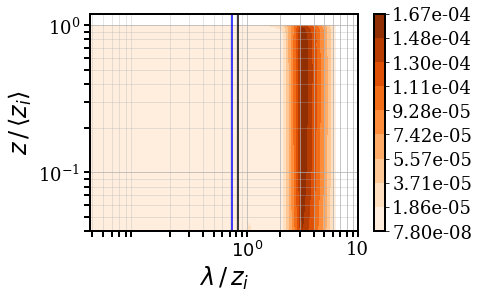

In [54]:
X, Y = np.meshgrid((1/spatial_freq_y)/zi, height_array/zi)
Z = (PS_array_x*spatial_freq_y)
levels = np.linspace(np.min(Z), np.max(Z), 10)
#levels = np.linspace(np.min(Z), 1.050e-04, 10)
#levels = np.linspace(np.min(Z), 5, 10)#wtheta, 2.839, 4.850-1100
#levels = np.linspace(np.min(Z), 5.925e-05, 10)#wq, 3.840, 5.925-1100
#q1.575e-04
# #for log scale
# lev_exp = np.arange(np.floor(np.log10(Z.min())-1),
#                    np.ceil(np.log10(Z.max())+1))
# levs = np.power(10, lev_exp)
#don't do log scale, not much variation in the iop02 runs
# plot
fig, ax = plt.subplots(figsize=(6,4))
#log scale
#im = ax.contourf(X, Y, Z,levels=levs, norm=mpl.colors.LogNorm(),cmap='Oranges')
im = ax.contourf(X, Y, Z,levels=levels,cmap='Oranges')

#1100, iop02
plt.axvline(x = T_length_y_scale_list[time_index]/zi, linestyle='-',color='black')
plt.axvline(x = q_length_y_scale_list[time_index]/zi, linestyle='-',color='blue')

# # 1200, iop02
# plt.axvline(x = 4334/zi, linestyle='-',color='black')
# plt.axvline(x = 4928/zi, linestyle='-',color='blue')


# # 1400, iop02
# plt.axvline(x = 4377/zi, linestyle='-',color='black')
# plt.axvline(x = 4987/zi, linestyle='-',color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_ylim([0.1,1.2])#iop02,1100
ax.set_ylim([0.04,1.2])#iop02,1400

ax.set_xlim([None,10])#iop01
#ax.set_xlim([1,10])#iop02

ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)
#ax.tick_params(width=2, length=4)
ax.tick_params(which = 'both',width=2, length=6)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.9)

positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
labels = ['', r'$10^{0}$', '', '', '','','','','','',10]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.colorbar(im, format='%.2e')

# output_fname = 'work/scale_analysis/plots/v20240618/IOP02_q_x_1200_hi.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

Continue making plots for theta, q and fluxes in the morning :)

##### Once again, normalise by the total surface flux value?

In [69]:
fname = 'DATA_3D_AV_NETCDF_N02slice'
data = open_concat_member_files(2,fname,iop)[['w','theta','q','wtheta','wq']].sel(time=time_step)

data['theta_interpolated'] = data.theta.rename({'zu_3d': 'zw_3d'}).interp_like(data.w)
data['q_interpolated'] = data.q.rename({'zu_3d': 'zw_3d'}).interp_like(data.w)

data['wtheta_turb'] = data['wtheta'] - data.w*data.theta_interpolated
data['wq_turb'] = data['wq'] - data.w*data.q_interpolated

wtheta_turb = data['wtheta_turb'].mean('x').mean('y').compute()
wq_turb = data['wq_turb'].mean('x').mean('y').compute()


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.34295876999385655 seconds


In [70]:
#surf_val = wtheta_turb.sel(zw_3d=60).values
surf_cov = wq_turb.sel(zw_3d=60).values

In [71]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(60,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array = []
#var = theta_hi_interpolated
var = q_hi_interpolated
for height in height_array:
    #print(height)
    w_data = w_hi.sel(zw_3d=height,method='nearest').values
    var_data = var.sel(zw_3d=height,method='nearest').values
    #var_data = ds.q_interpolated.sel(zw_3d=height,method='nearest').values
    #reshape into a square
    #cutting off the southernmost parts
    w_data_sq = w_data[108:,:]

    var_data_sq = var_data[108:,:]

    #take the fft!
    fourier_amps_w = fft.fftn(w_data_sq)
    fourier_amps_var = fft.fftn(var_data_sq)

    #k53 = (spatial_freq**(-2/3))
    PS2D = np.abs(fft.fftshift(fourier_amps_w)*np.conj(fft.fftshift(fourier_amps_var)))
    #for temp.
    PS1D = GetPSD1D(PS2D)[5:]
    #PS_array = PS1D
    #PS_array.append(PS1D/np.sum(PS1D))
    #normalize and convert to variance
    PS1D_normalised =  ((PS1D*(2/900**2))/10)/surf_cov
    PS_array.append(PS1D_normalised)


PS_array = np.asarray(PS_array)

spatial_freq = (fft.rfftfreq(w_data_sq.shape[0],30))[1:]
spatial_freq = spatial_freq[5:]


/tmp/ipykernel_2414399/4108741699.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,1.2])


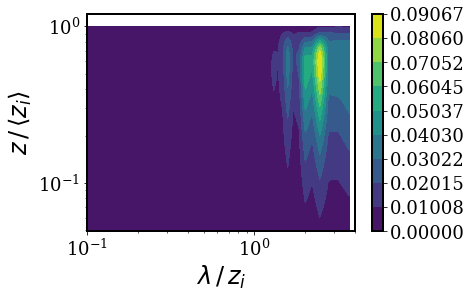

In [72]:
#30-min cospectra
X, Y = np.meshgrid((1/spatial_freq)/zi, height_array/zi)
Z = (PS_array*spatial_freq)
levels = np.linspace(np.min(Z), np.max(Z), 10)

# plot
fig, ax = plt.subplots(figsize=(6,4))

im = ax.contourf(X, Y, Z, levels=levels)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0,1.2])
ax.set_xlim([0.1,4])
ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)

plt.colorbar(im)
#plt.show()


##### Yeah, don't think it is imp. again. I want to see what scales contribute to the het. induced transport and how are they linked to surface scales...?

##### Will do the surface flux vs hi for IOP02

In [78]:
#got to first calculate w_hi and theta_hi

iop = 'iop02'
fname = 'DATA_3D_AV_NETCDF_N02slice'

member_num = np.arange(1,9) #iop02
time_index = 4

time_step = IOP02_time_array[time_index]
print(time_step)
#time_step = '2019-08-23T12:00:00.000000000'
#time_step = '2019-08-23T14:00:00.000000000'

zi = zi_iop02[time_index] #1100, iop02


2019-08-23T11:00:00.000000000


In [94]:
#surface fluxes
#PCM fluxes in the domains

H_PCM = (ensemble_member_ds_2_N02.sel(time=IOP02_time_array[time_index]).pcm_heatrate.sum('zpc_3d')*1.17*1005*12)

LE_PCM = (ensemble_member_ds_2_N02.sel(time=IOP02_time_array[time_index]).pcm_latentrate.sum('zpc_3d')*1.17*1005*12)


###---------------------------------------------------
#surface fluxes in the domains
H_surf = ensemble_member_surf_ds_2_N02.sel(time=IOP02_time_array[time_index])['shf*_xy']

LE_surf = ensemble_member_surf_ds_2_N02.sel(time=IOP02_time_array[time_index])['qsws*_xy']

net_H_kinematic = (H_surf+H_PCM)/(1.17*1005)
net_LE_kinematic = (LE_surf+LE_PCM)/(1.17*2501)


In [90]:
#hi values

data_list = []
#loop through the member list to select the 3D var value at the time step from each member
for member in member_num:
    #following line of code will concatenate all the data files of input_fname from member_num
    #and select the var at time sim_time
    ds = open_concat_member_files(member,fname,iop).sel(time=time_step)[['w','theta','q']]
    # #subset for the smaller domain
    # ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    #subset for the abl height
    ds = ds.sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    
    #append the data to the list
    data_list.append(ds)


ensemble_ds = xr.concat(data_list,'ensemble')    
print('Calculating hi datasets..')
print('w_hi..')
#hi datasets

w_ensemble_time_mean = ensemble_ds.w.mean('ensemble')
w_space_time_mean = ensemble_ds.w.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
w_hi = (w_ensemble_time_mean - w_space_time_mean).compute()

print('theta_hi..')
theta_ensemble_time_mean = ensemble_ds.theta.mean('ensemble')
theta_space_time_mean = ensemble_ds.theta.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
theta_hi = (theta_ensemble_time_mean - theta_space_time_mean).compute()
theta_hi_interpolated = theta_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)
print('q_hi..')
#calculate spatial_mean(wq_hi)
q_ensemble_time_mean = ensemble_ds.q.mean('ensemble')
q_space_time_mean = ensemble_ds.q.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
q_hi = (q_ensemble_time_mean - q_space_time_mean).compute()
q_hi_interpolated = q_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)



['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.36819636076688766 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3117842972278595 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.3116953782737255 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.309

In [91]:
wtheta_hi = w_hi*theta_hi_interpolated
wq_hi = w_hi*q_hi_interpolated


In [104]:
#np.save('work/scale_analysis/spectrograms/PS_wtheta_theta_iop02_1400_hi.npy', PS_array)

Load data if needed...

In [73]:

# #change file name before loading

# PS_array = np.load('work/scale_analysis/spectrograms/PS_wq_wq_iop02_1400_hi.npy')

# member = 2
# data_ds = open_concat_member_files(member,'DATA_3D_NETCDF_N02slice',iop)

# height_array = data_ds.w.sel(time=time_step).zw_3d.sel(zw_3d=slice(60,zi)).values 

# w_data = data_ds.w.sel(time=time_step,zw_3d=60).values
# w_data = w_data - np.mean(w_data)
# #reshape into a square
# #cutting off the southernmost parts
# w_data_sq = w_data[108:,:]

# #apply a hanning window
# Nx = var_data_sq.shape[0]
# Ny = var_data_sq.shape[1]        
# w_windowed_data = w_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

# spatial_freq = (fft.rfftfreq(w_windowed_data.shape[0],30))[1:]
# spatial_freq = spatial_freq[3:]


In [111]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array_x = []
PS_array_y = []
rotating_factor = 1000000

surf_cross_section = net_H_kinematic.squeeze().values
#surf_cross_section = net_LE_kinematic.squeeze().values

#select each of the variables for plotting by uncommenting
#var = w_hi

#var = theta_hi_interpolated
var = wtheta_hi

#var = q_hi_interpolated
#var = wq_hi

for height in height_array:
    #print(height)
    #rotate to the mean wind and subset to the smaller domain
    var_cross_section = var.sel(zw_3d=height,method='nearest').values    
    
    surf_data = rotate_var(surf_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]
     
    x = ds_2_het_iop02.x.values
    y = ds_2_het_iop02.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y_surf = surf_data[:,xloc]-surf_data[:,xloc].mean()
        data_x_surf = surf_data[yloc,:]-surf_data[yloc,:].mean()

        data_y_var = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x_var = var_data[yloc,:]-var_data[yloc,:].mean()


        # #-- apply bell taper to space series
        data_x_bt_surf = belltaper(data_x_surf,Nx)     
        data_y_bt_surf = belltaper(data_y_surf,Ny)

        data_x_bt_var = belltaper(data_x_var,Nx)     
        data_y_bt_var = belltaper(data_y_var,Ny)

        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt_surf)*np.conj(fftpack.fft(data_x_bt_var)))[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt_surf)*np.conj(fftpack.fft(data_y_bt_var)))[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/(w_star_iop02[time_index]*w_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*w_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*theta_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*theta_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*q_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*q_star_iop02[time_index]))


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)

[########################################] | 100% Completed | 101.80 ms


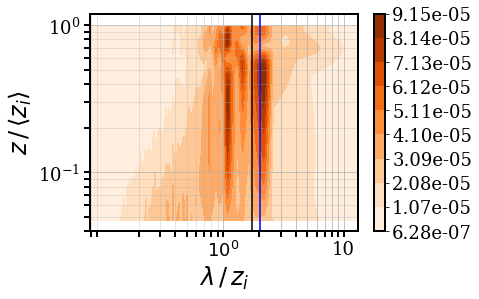

In [113]:

X, Y = np.meshgrid((1/spatial_freq_y)/zi, height_array/zi)
Z = (PS_array_y*spatial_freq_y)
levels = np.linspace(np.min(Z), np.max(Z), 10)
#levels = np.linspace(np.min(Z), 1.050e-04, 10)
#levels = np.linspace(np.min(Z), 5, 10)#wtheta, 2.839, 4.850-1100
#levels = np.linspace(np.min(Z), 5.925e-05, 10)#wq, 3.840, 5.925-1100
#q1.575e-04
# #for log scale
# lev_exp = np.arange(np.floor(np.log10(Z.min())-1),
#                    np.ceil(np.log10(Z.max())+1))
# levs = np.power(10, lev_exp)
#don't do log scale, not much variation in the iop02 runs
# plot
fig, ax = plt.subplots(figsize=(6,4))
#log scale
#im = ax.contourf(X, Y, Z,levels=levs, norm=mpl.colors.LogNorm(),cmap='Oranges')
im = ax.contourf(X, Y, Z,levels=levels,cmap='Oranges')

#1100, iop02
plt.axvline(x = T_length_y_scale_list[time_index]/zi, linestyle='-',color='black')
plt.axvline(x = q_length_y_scale_list[time_index]/zi, linestyle='-',color='blue')

# # 1200, iop02
# plt.axvline(x = 4334/zi, linestyle='-',color='black')
# plt.axvline(x = 4928/zi, linestyle='-',color='blue')


# # 1400, iop02
# plt.axvline(x = 4377/zi, linestyle='-',color='black')
# plt.axvline(x = 4987/zi, linestyle='-',color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_ylim([0.1,1.2])#iop02,1100
ax.set_ylim([0.04,1.2])#iop02,1400

#ax.set_xlim([None,10])#iop01
#ax.set_xlim([1,10])#iop02

ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)
#ax.tick_params(width=2, length=4)
ax.tick_params(which = 'both',width=2, length=6)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.9)

positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
labels = ['', r'$10^{0}$', '', '', '','','','','','',10]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.colorbar(im, format='%.2e')

output_fname = 'work/scale_analysis/plots/v20240618/IOP02_wtheta0_wtheta_1100_hi.png'
plt.savefig(output_fname,dpi=300, bbox_inches="tight")



In [93]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

#### IOP03

1200 24 Sep:

In [55]:

iop = 'iop03'
fname = 'DATA_3D_AV_NETCDF_N02slice'

member_num = np.arange(0,8) #iop03
time_index = 6

time_step = IOP03_time_array[time_index]
print(time_step)
#time_step = '2019-08-23T12:00:00.000000000'
#time_step = '2019-08-23T14:00:00.000000000'

zi = zi_iop03[time_index] #1200, iop03

2019-09-24T12:00:00.000000000


In [56]:
data_list = []
#loop through the member list to select the 3D var value at the time step from each member
for member in member_num:
    #following line of code will concatenate all the data files of input_fname from member_num
    #and select the var at time sim_time
    ds = open_concat_member_files(member,fname,iop).sel(time=time_step)[['w','theta','q','v']]
    # #subset for the smaller domain
    # ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    #subset for the abl height
    ds = ds.sel(zu_3d=slice(None,zi_iop03[time_index]+200),zw_3d=slice(None,zi_iop03[time_index]+200))
    
    #append the data to the list
    data_list.append(ds)


ensemble_ds = xr.concat(data_list,'ensemble')    


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  1.1103852726519108 seconds
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.41185636073350906 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.32459

In [57]:

print('Calculating hi datasets..')
print('w_hi..')
#hi datasets

w_ensemble_time_mean = ensemble_ds.w.mean('ensemble')
w_space_time_mean = ensemble_ds.w.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
w_hi = (w_ensemble_time_mean - w_space_time_mean).compute()

print('theta_hi..')
theta_ensemble_time_mean = ensemble_ds.theta.mean('ensemble')
theta_space_time_mean = ensemble_ds.theta.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
theta_hi = (theta_ensemble_time_mean - theta_space_time_mean).compute()
theta_hi_interpolated = theta_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)
print('q_hi..')
#calculate spatial_mean(wq_hi)
q_ensemble_time_mean = ensemble_ds.q.mean('ensemble')
q_space_time_mean = ensemble_ds.q.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
q_hi = (q_ensemble_time_mean - q_space_time_mean).compute()
q_hi_interpolated = q_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)

Calculating hi datasets..
w_hi..
[########################################] | 100% Completed | 4.95 sms
theta_hi..
[########################################] | 100% Completed | 4.44 sms
q_hi..
[########################################] | 100% Completed | 3.54 sms


just checking out the streamwise wind plots:

In [39]:
def sine_taper(n):
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    return np.asarray(W)

In [58]:
wind_angle = mean_wind_dir_degrees_12_iop03 = 72.4

In [59]:
angle_theta = np.radians(wind_angle)
streamwise_wind = ensemble_ds.v/(np.sin(angle_theta))


In [60]:
streamwise_wind = streamwise_wind.rename({'yv':'y'}).interp_like(w_hi)

streamwise_wind_ensemble_time_mean = streamwise_wind.mean('ensemble')
streamwise_wind_space_time_mean = streamwise_wind.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')

streamwise_wind_hi = (streamwise_wind_ensemble_time_mean - streamwise_wind_space_time_mean).compute()
streamwise_wind_hi_interpolated = streamwise_wind_hi.rename({'zu_3d': 'zw_3d'}).interp_like(w_hi)


[########################################] | 100% Completed | 7.48 sms


##### Spectra:

In [71]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 

PS_array_x = []
PS_array_y = []
rotating_factor = 1000000
#var = w_hi
#var = theta_hi_interpolated
#var = q_hi_interpolated
var = streamwise_wind_hi_interpolated

for height in height_array:
    #print(height)
    #rotate to the mean wind and subset to the smaller domain
    var_cross_section = var.sel(zw_3d=height,method='nearest').values    
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle)[x_min:x_max,y_min:y_max]
     
    x = ds_2_het_iop03.x.values
    y = ds_2_het_iop03.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x = var_data[yloc,:]-var_data[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        data_x_bt = belltaper(data_x,Nx)     
        data_y_bt = belltaper(data_y,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt)**2)[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt)**2)[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/w_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/w_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/theta_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/theta_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/q_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/q_star_iop02[time_index]**2)


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)

##### cospectra code:

In [74]:
height_array = w_hi.zw_3d.sel(zw_3d=slice(30,zi)).values 
#height_array = ensemble_member_ds_2_N02_inst.q.sel(time=time_step).zu_3d.sel(zu_3d=slice(60,0.8*zi)).values 
PS_array_x = []
PS_array_y = []
rotating_factor = 1000000
#var = w_hi
#var = theta_hi_interpolated
var = q_hi_interpolated
for height in height_array:
    #print(height)
    #rotate to the mean wind and subset to the smaller domain
    w_cross_section = w_hi.sel(zw_3d=height,method='nearest').values    
    var_cross_section = var.sel(zw_3d=height,method='nearest').values    
    
    w_data = rotate_var(w_cross_section,rotating_factor,wind_angle)[x_min:x_max,y_min:y_max]
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle)[x_min:x_max,y_min:y_max]
     
    x = ds_2_het_iop03.x.values
    y = ds_2_het_iop03.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y_w = w_data[:,xloc]-w_data[:,xloc].mean()
        data_x_w = w_data[yloc,:]-w_data[yloc,:].mean()

        data_y_var = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x_var = var_data[yloc,:]-var_data[yloc,:].mean()


        # #-- apply bell taper to space series
        data_x_bt_w = belltaper(data_x_w,Nx)     
        data_y_bt_w = belltaper(data_y_w,Ny)

        data_x_bt_var = belltaper(data_x_var,Nx)     
        data_y_bt_var = belltaper(data_y_var,Ny)

        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt_w)*np.conj(fftpack.fft(data_x_bt_var)))[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt_w)*np.conj(fftpack.fft(data_y_bt_var)))[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/(w_star_iop02[time_index]*w_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*w_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*theta_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*theta_star_iop02[time_index]))

    # PS_array_x.append(S_x/(w_star_iop02[time_index]*q_star_iop02[time_index]))
    # PS_array_y.append(S_y/(w_star_iop02[time_index]*q_star_iop02[time_index]))


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)

In [62]:
T_length_x_scale_list_iop03 = [331.5153111299058, 981.4544347067848, 976.7571878649379, 969.2773951259537, 969.8143334894692, 1097.562499200825, 1074.7372064641297, 1074.9676746081968, 1035.6585405510082, 1060.448801383857, 1047.9952854725009, 1029.1431479798027]
T_length_y_scale_list_iop03 = [408.2035289613767, 734.9298205812214, 709.1614104566582, 698.4646117098976, 697.6151483818605, 939.1699185628564, 957.9288203817491, 909.5036284429358, 895.435484989907, 897.3899976814932, 903.6183473612106, 891.1802669440997]

q_length_x_scale_list_iop03 = [457.6845248431102, 990.3731254744658, 898.3391808105795, 872.8621996973051, 862.525238423193, 964.0357729800289, 851.9527485449937, 768.963596601518, 768.5607922956425, 710.1725515329075, 705.9003440501037, 743.64165900239]
q_length_y_scale_list_iop03 = [503.2523368186288, 709.7722181542999, 604.302871151966, 567.012628071264, 546.100887849163, 832.7564117726804, 826.1835204343954, 821.8449889235376, 783.3520687042954, 763.8802597227267, 766.780312744567, 793.8108889835277]


##### Plot:

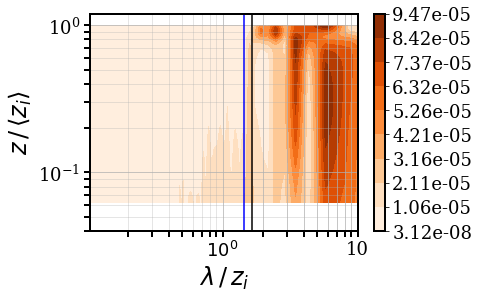

In [77]:
X, Y = np.meshgrid((1/spatial_freq_y)/zi, height_array/zi)
Z = (PS_array_y*spatial_freq_y)
levels = np.linspace(np.min(Z), np.max(Z), 10)
#levels = np.linspace(np.min(Z), 1.050e-04, 10)
#levels = np.linspace(np.min(Z), 5, 10)#wtheta, 2.839, 4.850-1100
#levels = np.linspace(np.min(Z), 5.925e-05, 10)#wq, 3.840, 5.925-1100
#q1.575e-04
# #for log scale
# lev_exp = np.arange(np.floor(np.log10(Z.min())-1),
#                    np.ceil(np.log10(Z.max())+1))
# levs = np.power(10, lev_exp)
#don't do log scale, not much variation in the iop02 runs
# plot
fig, ax = plt.subplots(figsize=(6,4))
#log scale
#im = ax.contourf(X, Y, Z,levels=levs, norm=mpl.colors.LogNorm(),cmap='Oranges')
im = ax.contourf(X, Y, Z,levels=levels,cmap='Oranges')

#1100, iop02
plt.axvline(x = T_length_y_scale_list_iop03[time_index]/zi, linestyle='-',color='black')
plt.axvline(x = q_length_y_scale_list_iop03[time_index]/zi, linestyle='-',color='blue')

# # 1200, iop02
# plt.axvline(x = 4334/zi, linestyle='-',color='black')
# plt.axvline(x = 4928/zi, linestyle='-',color='blue')


# # 1400, iop02
# plt.axvline(x = 4377/zi, linestyle='-',color='black')
# plt.axvline(x = 4987/zi, linestyle='-',color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_ylim([0.1,1.2])#iop02,1100
ax.set_ylim([0.04,1.2])#iop02,1400

ax.set_xlim([None,10])#iop01
#ax.set_xlim([1,10])#iop02

ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.set_xlabel(r'$\lambda\, /\, z_{i} $',fontsize=24)
#ax.tick_params(width=2, length=4)
ax.tick_params(which = 'both',width=2, length=6)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.9)

positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
labels = ['', r'$10^{0}$', '', '', '','','','','','',10]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.colorbar(im, format='%.2e')

# output_fname = 'work/scale_analysis/plots/v20240618/IOP03_wq_1200_hi.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

In [56]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'